In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# Importar librerías necesarias RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Importar librerías necesarias ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')



In [2]:
# Cargar los DataFrames desde archivos Excel
path_df_location = "../dataset/df_historic_order_demand.xlsx"
df_historic_order_demand = pd.read_excel(path_df_location)

df_historic_order_demand


cliente mes_anio  order_demand
0     Cliente_1  12-2020         857.0
1     Cliente_2  12-2020         941.0
2     Cliente_3  12-2020         878.0
3     Cliente_4  12-2020         949.0
4     Cliente_5  12-2020         932.0
..          ...      ...           ...
975  Cliente_16  12-2024         891.0
976  Cliente_17  12-2024         968.0
977  Cliente_18  12-2024         972.0
978  Cliente_19  12-2024         901.0
979  Cliente_20  12-2024         881.0

[980 rows x 3 columns]

In [3]:
# Explorar la estructura del DataFrame
print("Primeras filas del DataFrame:")
print(df_historic_order_demand.head())

print("\nInformación del DataFrame:")
print(df_historic_order_demand.info())

# Verificar si hay valores nulos
print("\nValores nulos por columna:")
print(df_historic_order_demand.isnull().sum())


Primeras filas del DataFrame:
     cliente mes_anio  order_demand
0  Cliente_1  12-2020         857.0
1  Cliente_2  12-2020         941.0
2  Cliente_3  12-2020         878.0
3  Cliente_4  12-2020         949.0
4  Cliente_5  12-2020         932.0

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cliente       980 non-null    object 
 1   mes_anio      980 non-null    object 
 2   order_demand  932 non-null    float64
dtypes: float64(1), object(2)
memory usage: 23.1+ KB
None

Valores nulos por columna:
cliente          0
mes_anio         0
order_demand    48
dtype: int64


In [4]:
# Crear un nuevo DataFrame a partir del original
df_historicod_time = df_historic_order_demand.copy()

# Añadir la nueva columna 'mes_anio_dia' asumiendo el primer día del mes para todas las entradas
df_historicod_time['mes_anio_dia'] = pd.to_datetime(df_historicod_time['mes_anio'].apply(lambda x: f"01-{x}"), format='%d-%m-%Y', errors='coerce')

# Verificar si hay valores nulos en la nueva columna en el nuevo DataFrame
print("\nValores nulos en 'mes_anio_dia' del nuevo DataFrame:")
print(df_historicod_time['mes_anio_dia'].isnull().sum())



Valores nulos en 'mes_anio_dia' del nuevo DataFrame:
0


In [5]:
# Verificar si hay duplicados basados en 'cliente' y 'mes_anio_dia' en el nuevo DataFrame
print("Registros duplicados en df_historicod_time:")
print(df_historicod_time.duplicated(subset=['cliente', 'mes_anio_dia']).sum())

df_historicod_time

Registros duplicados en df_historicod_time:
0


cliente mes_anio  order_demand mes_anio_dia
0     Cliente_1  12-2020         857.0   2020-12-01
1     Cliente_2  12-2020         941.0   2020-12-01
2     Cliente_3  12-2020         878.0   2020-12-01
3     Cliente_4  12-2020         949.0   2020-12-01
4     Cliente_5  12-2020         932.0   2020-12-01
..          ...      ...           ...          ...
975  Cliente_16  12-2024         891.0   2024-12-01
976  Cliente_17  12-2024         968.0   2024-12-01
977  Cliente_18  12-2024         972.0   2024-12-01
978  Cliente_19  12-2024         901.0   2024-12-01
979  Cliente_20  12-2024         881.0   2024-12-01

[980 rows x 4 columns]

In [6]:
# Ordenar primero por cliente y luego por mes_anio_dia en df_historicod_time
df_historicod_time = df_historicod_time.sort_values(by=['cliente', 'mes_anio_dia']).reset_index(drop=True)

# Verificar la estructura después de ordenar
print("Estructura de df_historicod_time después de ordenar:")
print(df_historicod_time.head())


Estructura de df_historicod_time después de ordenar:
     cliente mes_anio  order_demand mes_anio_dia
0  Cliente_1  12-2020         857.0   2020-12-01
1  Cliente_1  01-2021         768.0   2021-01-01
2  Cliente_1  02-2021         635.0   2021-02-01
3  Cliente_1  03-2021         631.0   2021-03-01
4  Cliente_1  04-2021         589.0   2021-04-01


In [7]:
# Mostrar número de valores nulos en la columna 'order_demand' de df_historicod_time
print("\nValores nulos en 'order_demand' de df_historicod_time:")
print(df_historicod_time['order_demand'].isnull().sum())

# Mostrar las filas que contienen valores nulos en 'order_demand' en df_historicod_time
print("\nFilas con valores nulos en 'order_demand' de df_historicod_time:")
print(df_historicod_time[df_historicod_time['order_demand'].isnull()])



Valores nulos en 'order_demand' de df_historicod_time:
48

Filas con valores nulos en 'order_demand' de df_historicod_time:
        cliente mes_anio  order_demand mes_anio_dia
55   Cliente_10  06-2021           NaN   2021-06-01
65   Cliente_10  04-2022           NaN   2022-04-01
89   Cliente_10  04-2024           NaN   2024-04-01
92   Cliente_10  07-2024           NaN   2024-07-01
109  Cliente_11  11-2021           NaN   2021-11-01
124  Cliente_11  02-2023           NaN   2023-02-01
128  Cliente_11  06-2023           NaN   2023-06-01
140  Cliente_11  06-2024           NaN   2024-06-01
169  Cliente_12  10-2022           NaN   2022-10-01
173  Cliente_12  02-2023           NaN   2023-02-01
205  Cliente_13  09-2021           NaN   2021-09-01
211  Cliente_13  03-2022           NaN   2022-03-01
229  Cliente_13  09-2023           NaN   2023-09-01
234  Cliente_13  02-2024           NaN   2024-02-01
253  Cliente_14  08-2021           NaN   2021-08-01
254  Cliente_14  09-2021           NaN   20

In [8]:
# Sustituir valores nulos en 'order_demand' por la media del cliente en df_historicod_time
df_historicod_time['order_demand'] = df_historicod_time.groupby('cliente')['order_demand'].transform(lambda x: x.fillna(x.mean()))

# Verificar si quedan valores nulos
print("\nVerificación de valores nulos después de la sustitución en 'order_demand':")
print(df_historicod_time['order_demand'].isnull().sum())

# Mostrar algunas filas para verificar cambios
print(df_historicod_time.head())



Verificación de valores nulos después de la sustitución en 'order_demand':
0
     cliente mes_anio  order_demand mes_anio_dia
0  Cliente_1  12-2020         857.0   2020-12-01
1  Cliente_1  01-2021         768.0   2021-01-01
2  Cliente_1  02-2021         635.0   2021-02-01
3  Cliente_1  03-2021         631.0   2021-03-01
4  Cliente_1  04-2021         589.0   2021-04-01


Dividir los Datos por Cliente


In [9]:
# Crear un diccionario para almacenar los datos por cliente
clientes_data = {}

# Iterar por cada cliente único y guardar sus datos en un DataFrame
for cliente in df_historicod_time['cliente'].unique():
    datos_cliente = df_historicod_time[df_historicod_time['cliente'] == cliente]
    
    # Solo incluir si hay datos válidos para análisis temporal
    if datos_cliente['order_demand'].notnull().sum() > 12:  # Al menos 12 puntos de datos
        clientes_data[cliente] = datos_cliente

# Confirmar cuántos clientes tienen datos suficientes para análisis
print(f"{len(clientes_data)} clientes tienen datos suficientes para análisis temporal.")

clientes_data

20 clientes tienen datos suficientes para análisis temporal.


{'Cliente_1':       cliente mes_anio  order_demand mes_anio_dia
 0   Cliente_1  12-2020         857.0   2020-12-01
 1   Cliente_1  01-2021         768.0   2021-01-01
 2   Cliente_1  02-2021         635.0   2021-02-01
 3   Cliente_1  03-2021         631.0   2021-03-01
 4   Cliente_1  04-2021         589.0   2021-04-01
 5   Cliente_1  05-2021         785.0   2021-05-01
 6   Cliente_1  06-2021         798.0   2021-06-01
 7   Cliente_1  07-2021         599.0   2021-07-01
 8   Cliente_1  08-2021         570.0   2021-08-01
 9   Cliente_1  09-2021         589.0   2021-09-01
 10  Cliente_1  10-2021        1848.0   2021-10-01
 11  Cliente_1  11-2021         597.0   2021-11-01
 12  Cliente_1  12-2021         886.0   2021-12-01
 13  Cliente_1  01-2022         699.0   2022-01-01
 14  Cliente_1  02-2022         609.0   2022-02-01
 15  Cliente_1  03-2022         633.0   2022-03-01
 16  Cliente_1  04-2022         563.0   2022-04-01
 17  Cliente_1  05-2022         816.0   2022-05-01
 18  Cliente_1  06

EDA clientes_data

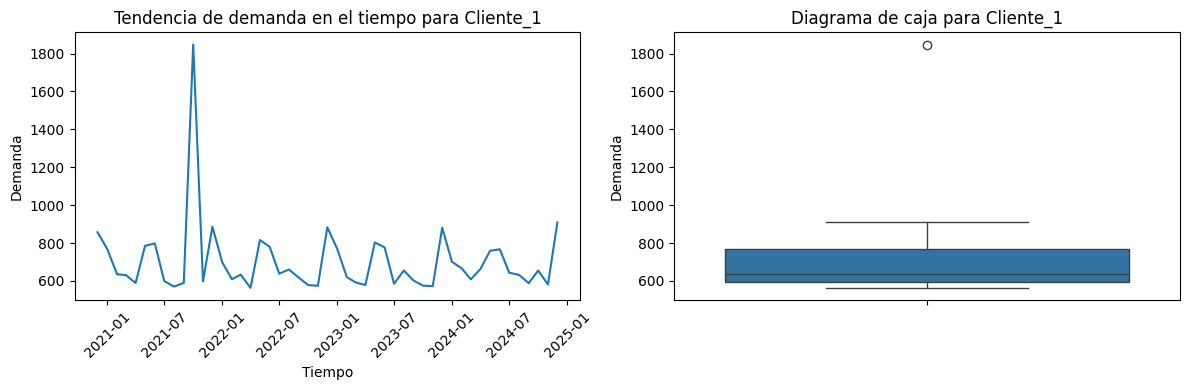

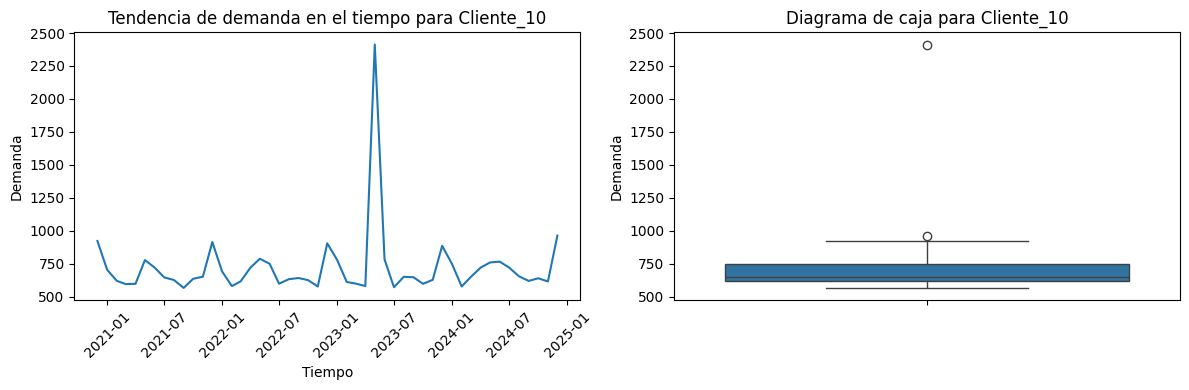

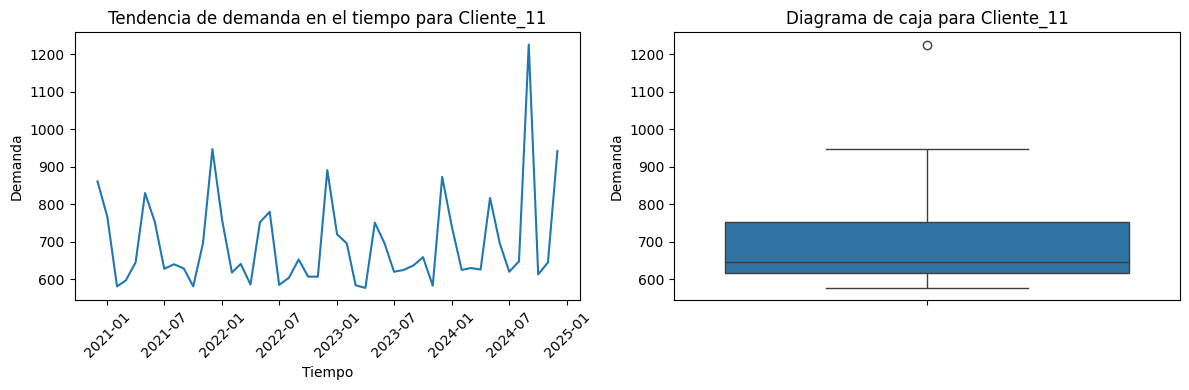

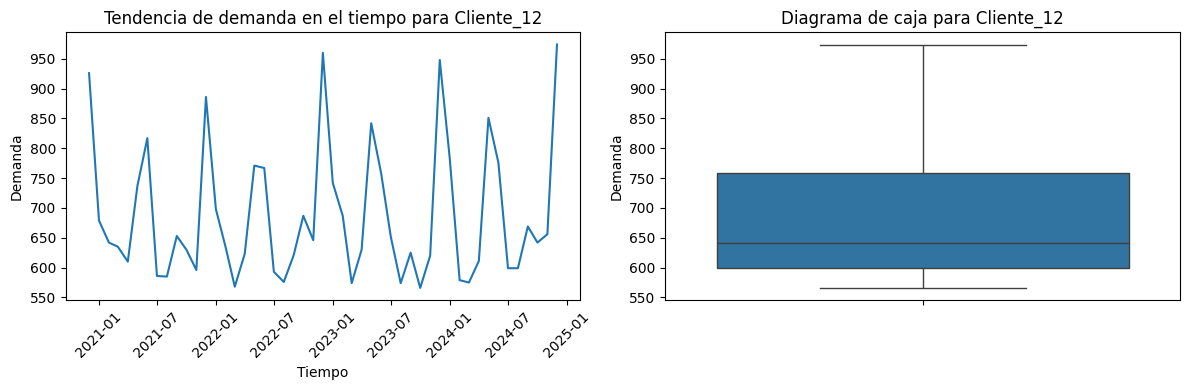

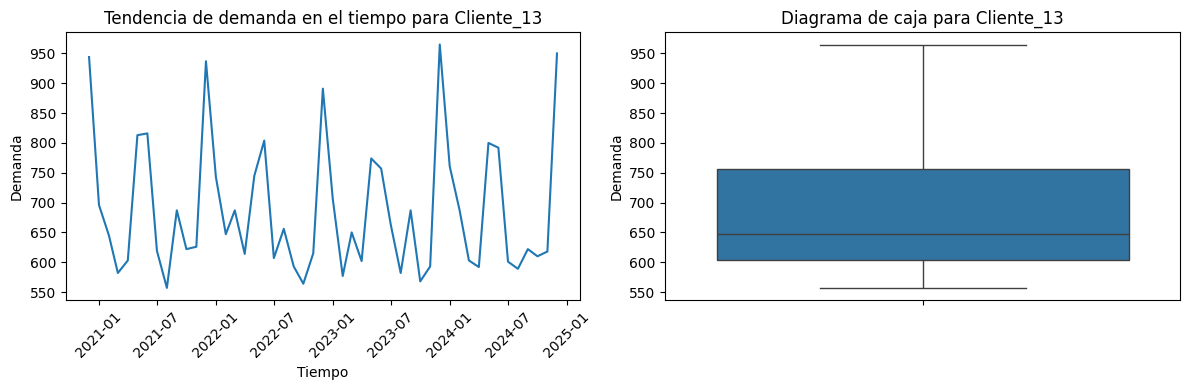

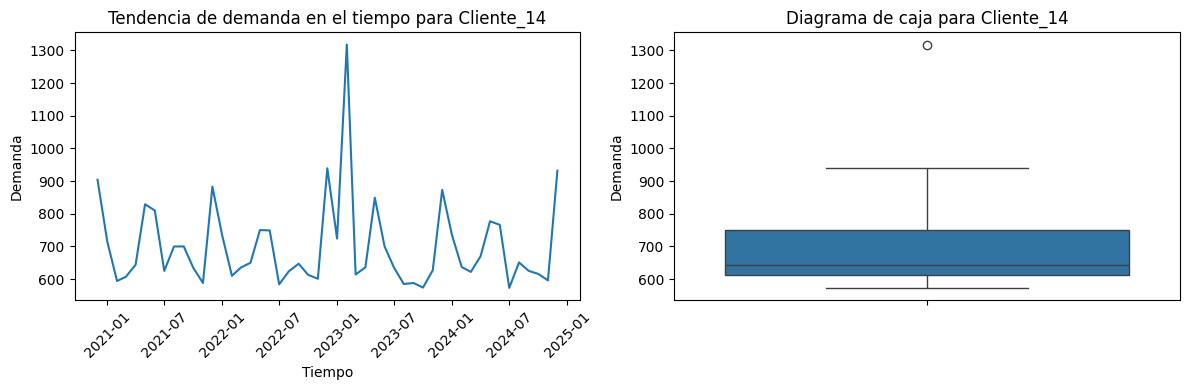

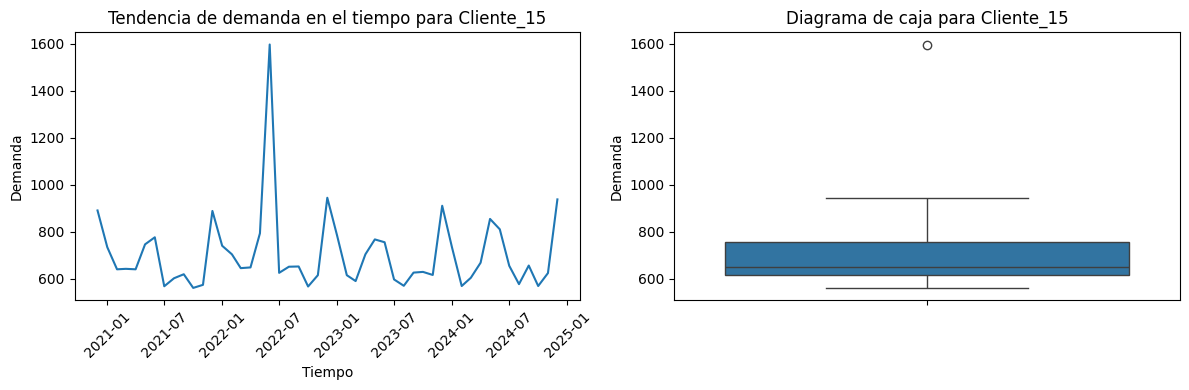

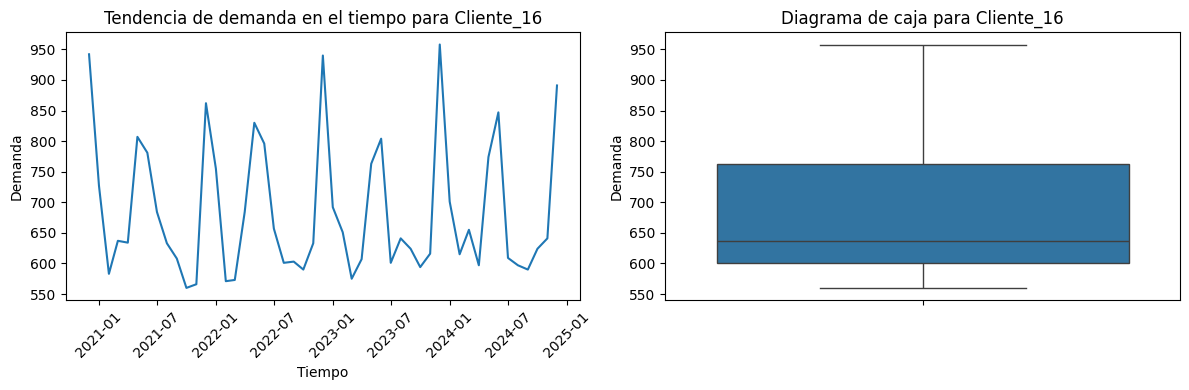

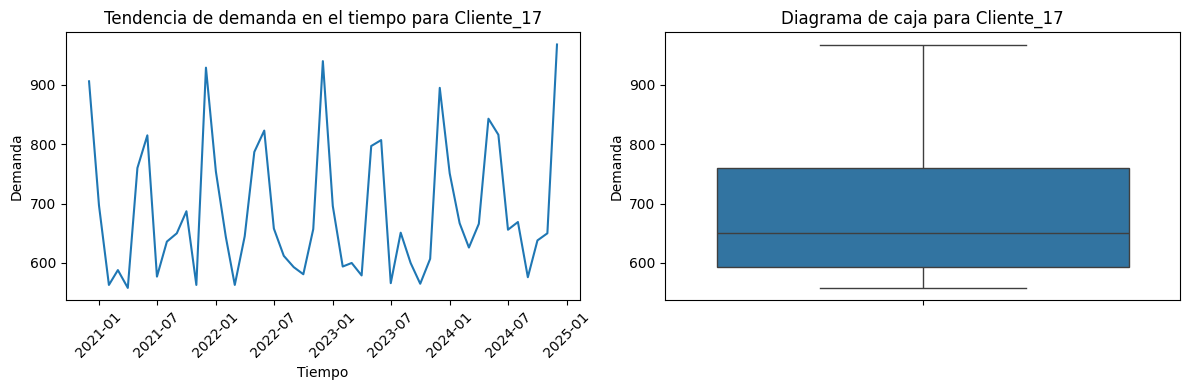

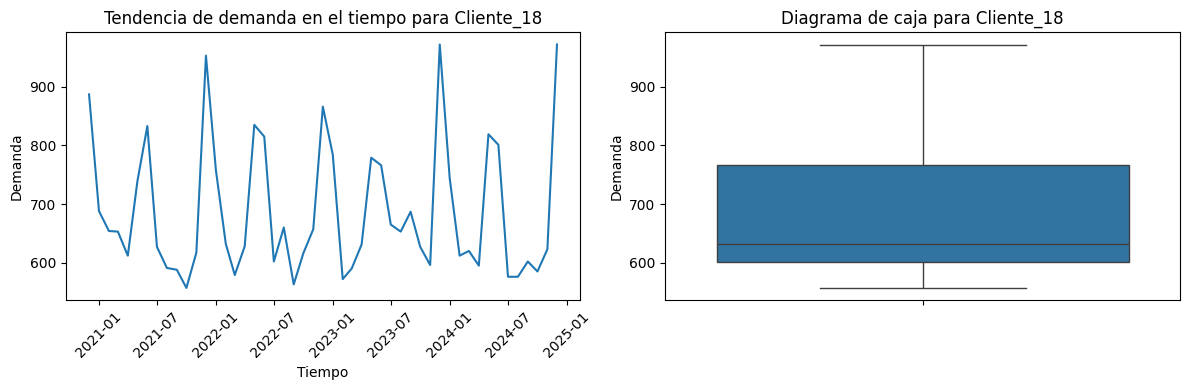

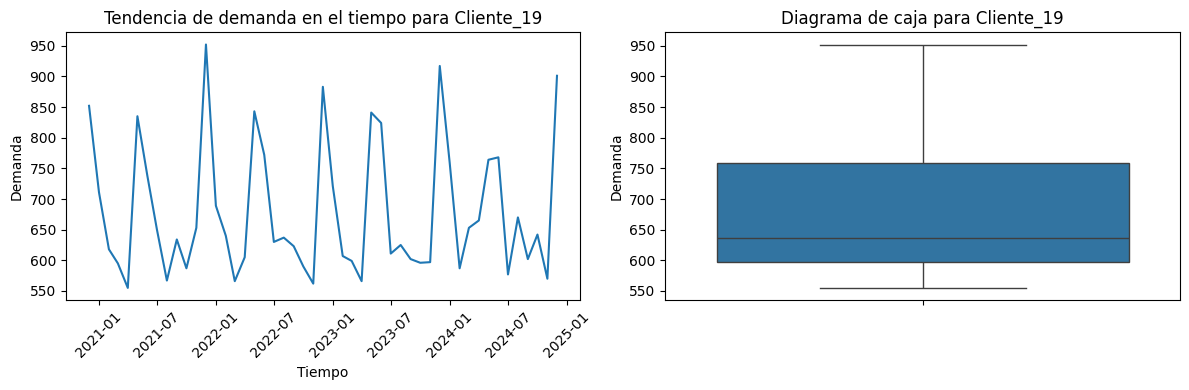

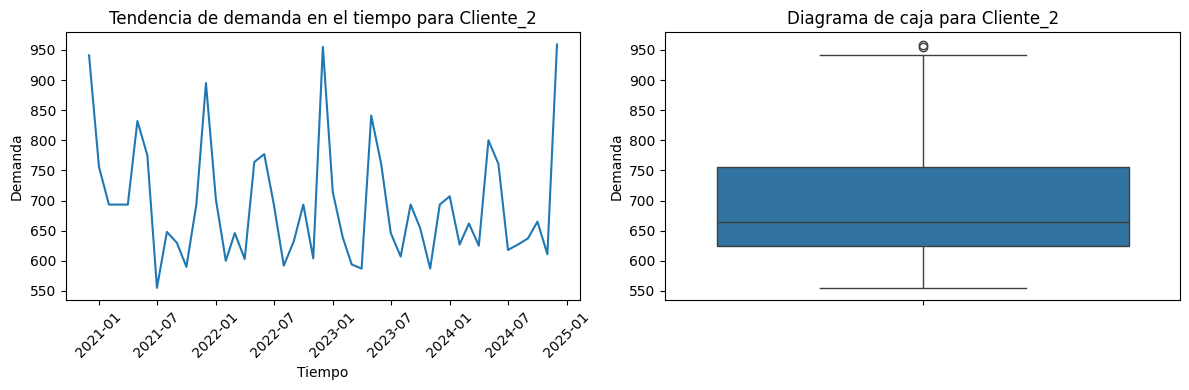

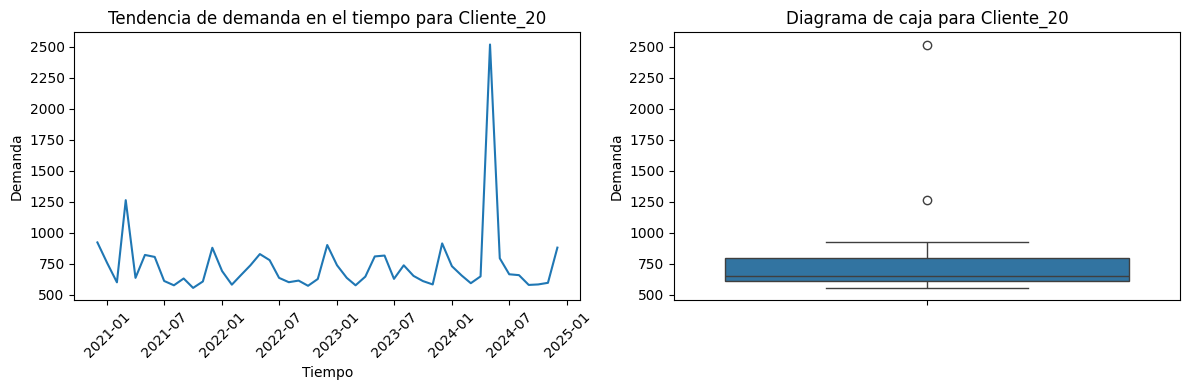

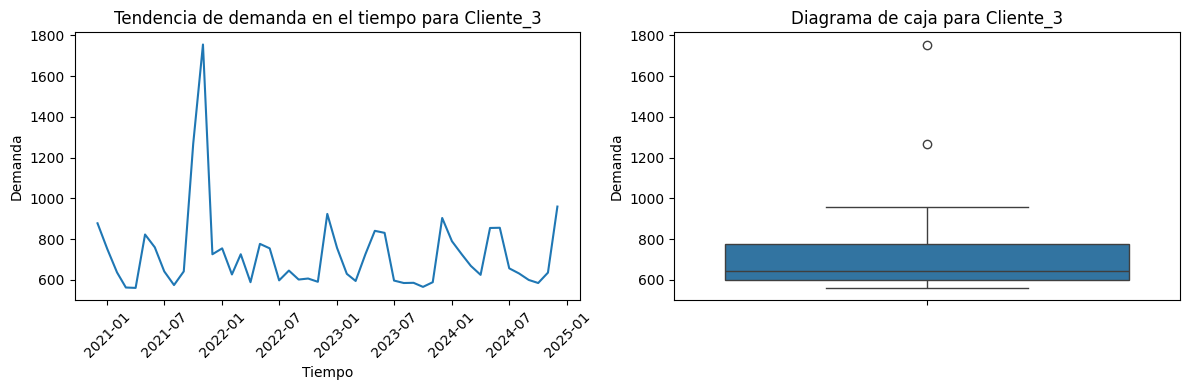

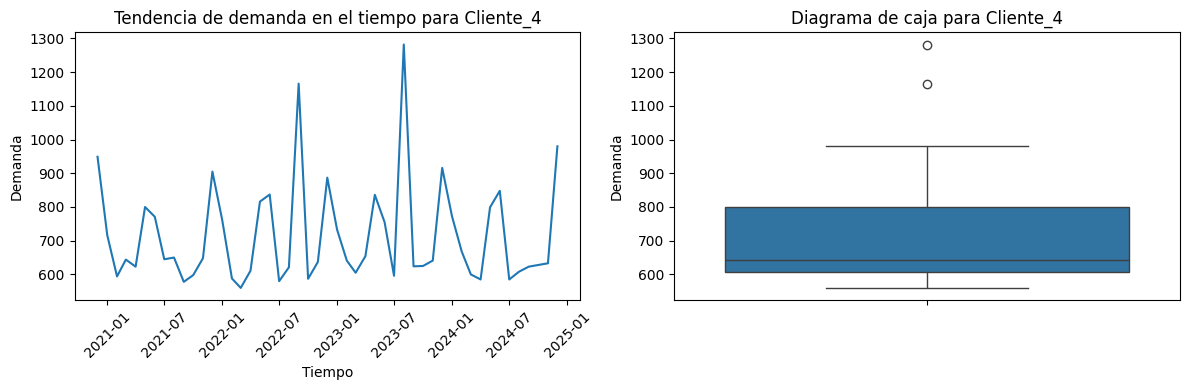

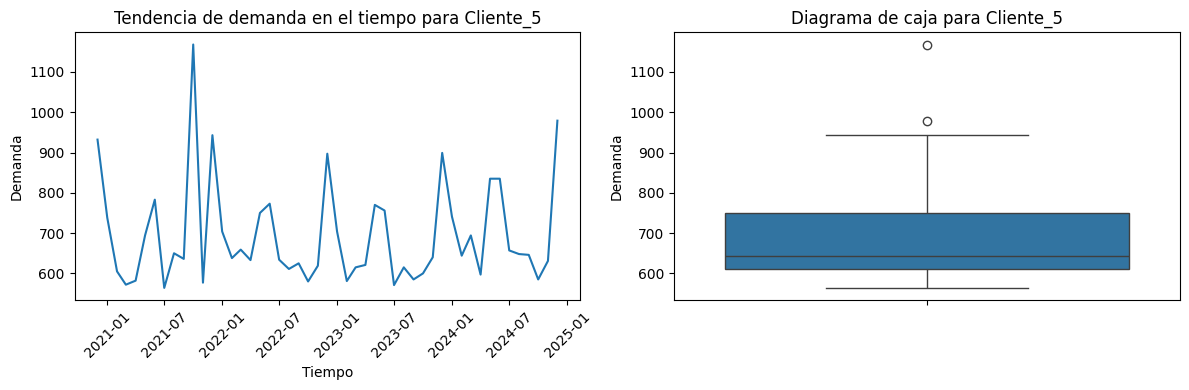

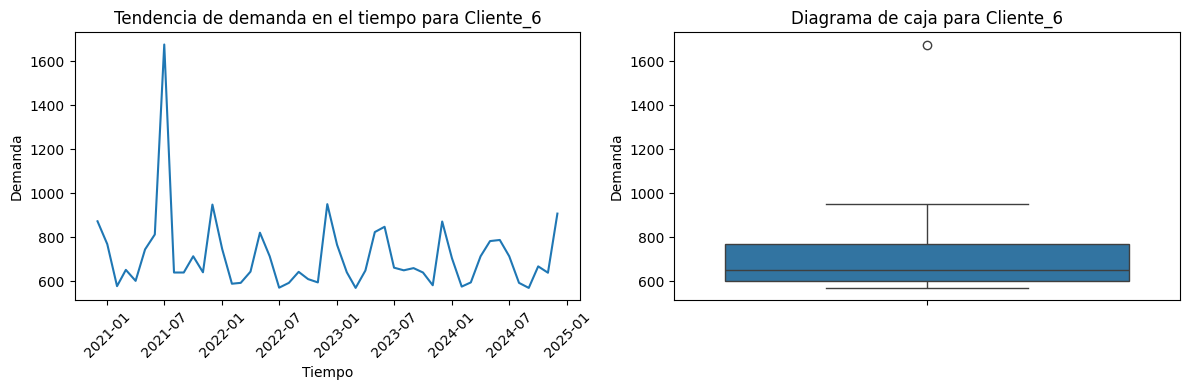

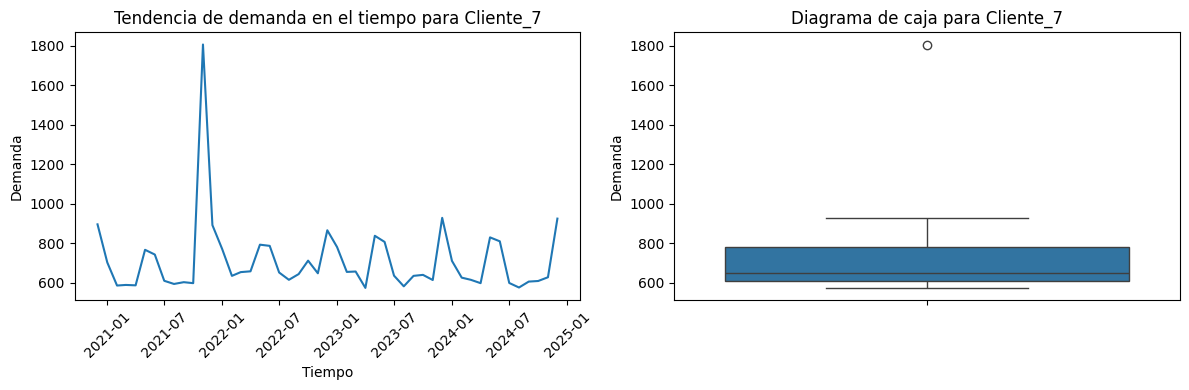

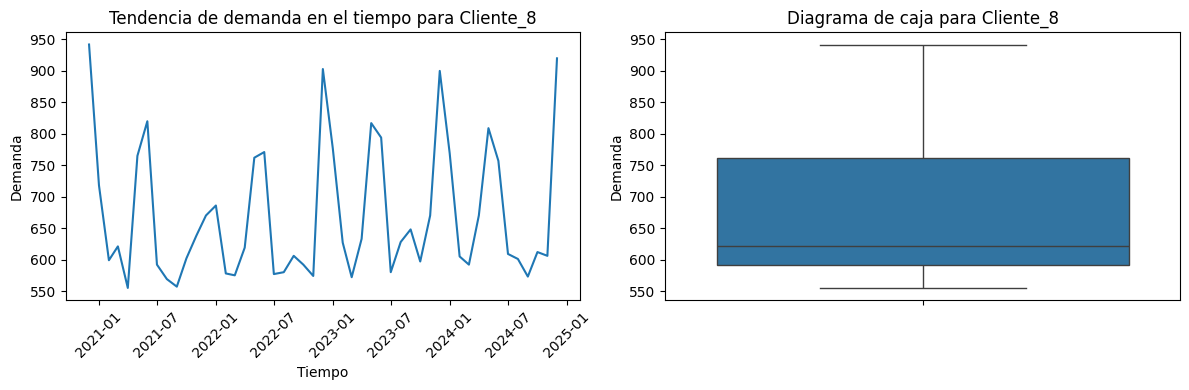

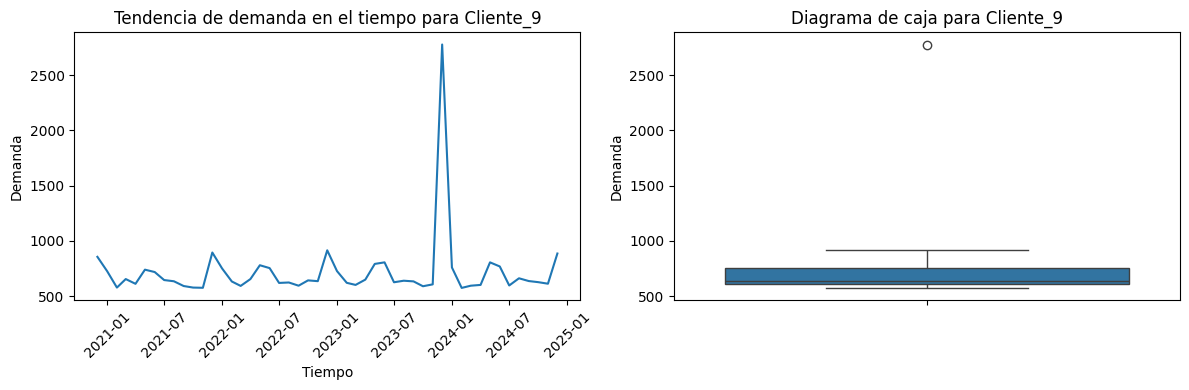

In [66]:
# Visualización de Tendencias y Patrones:

for cliente, df in clientes_data.items():
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 fila, 2 columnas
    
    # Histograma de la demanda a lo largo del tiempo
    sns.lineplot(data=df, x='mes_anio_dia', y='order_demand', ax=axes[0])
    axes[0].set_title(f"Tendencia de demanda en el tiempo para {cliente}")
    axes[0].set_xlabel("Tiempo")
    axes[0].set_ylabel("Demanda")
    axes[0].tick_params(axis='x', rotation=45)  # Rotar etiquetas del eje X si es necesario

    # Diagrama de caja con 'order_demand' en el eje Y
    sns.boxplot(y=df['order_demand'], ax=axes[1])
    axes[1].set_title(f"Diagrama de caja para {cliente}")
    axes[1].set_ylabel("Demanda")
    
    plt.tight_layout()  # Ajusta el espaciado entre gráficos
    plt.show()


1. Descomposición de Series Temporales

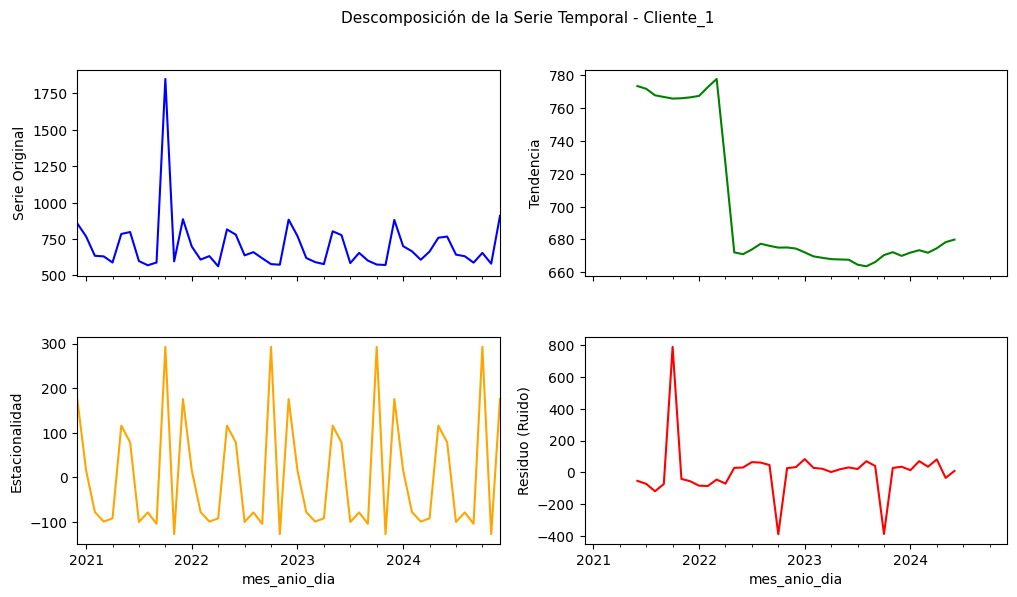

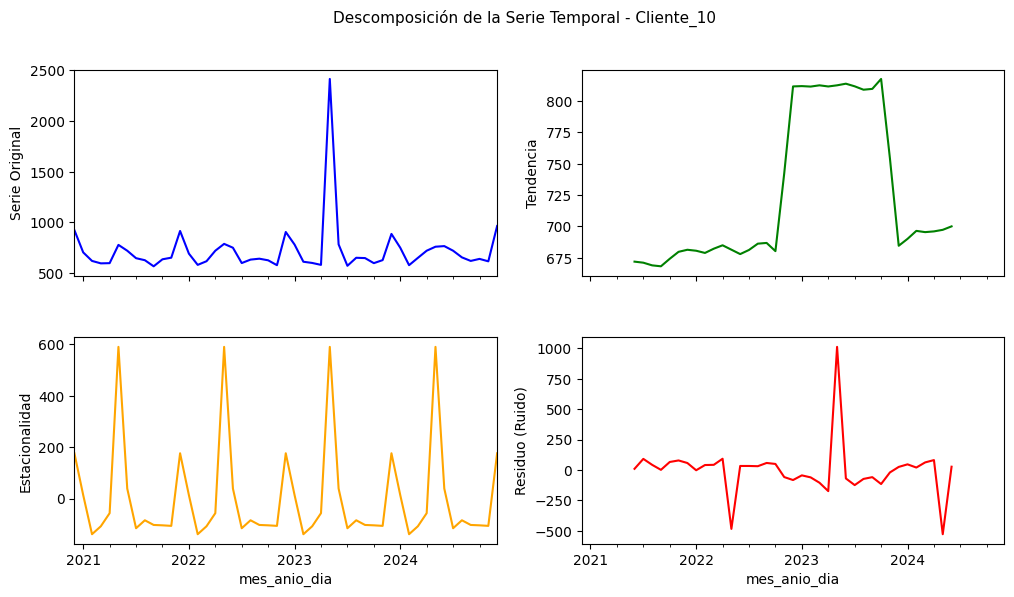

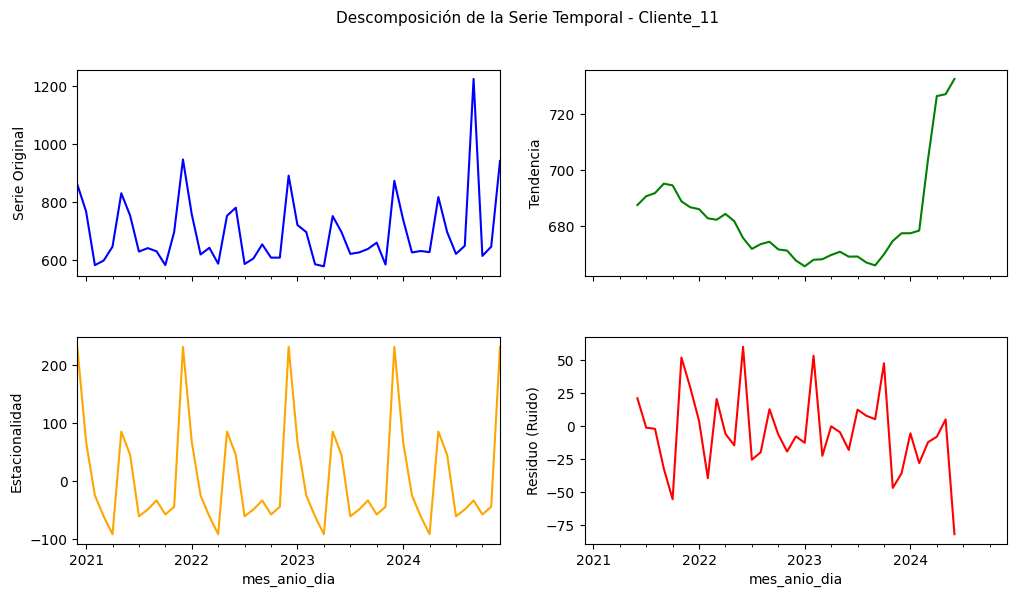

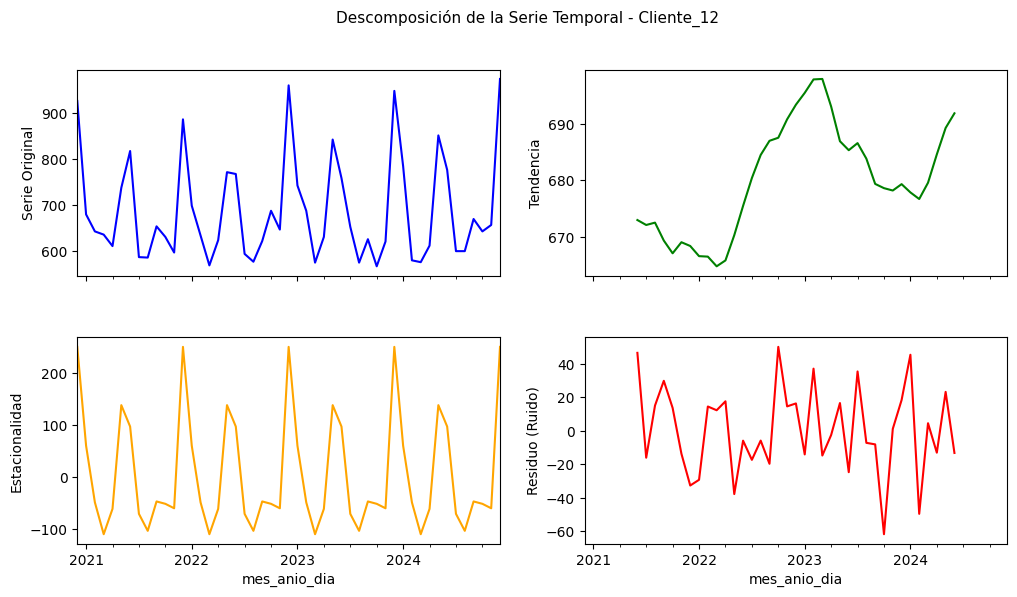

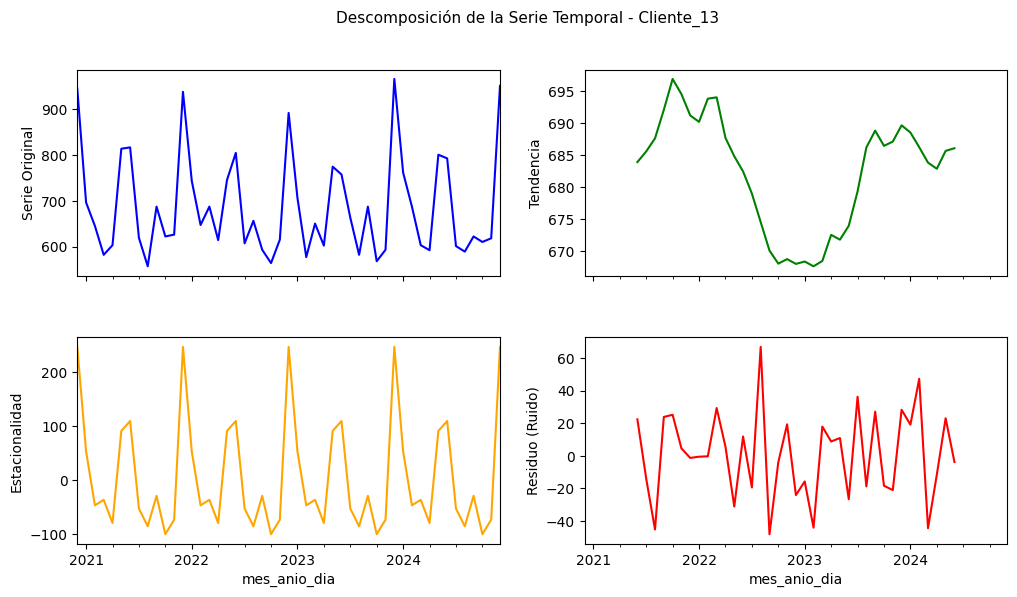

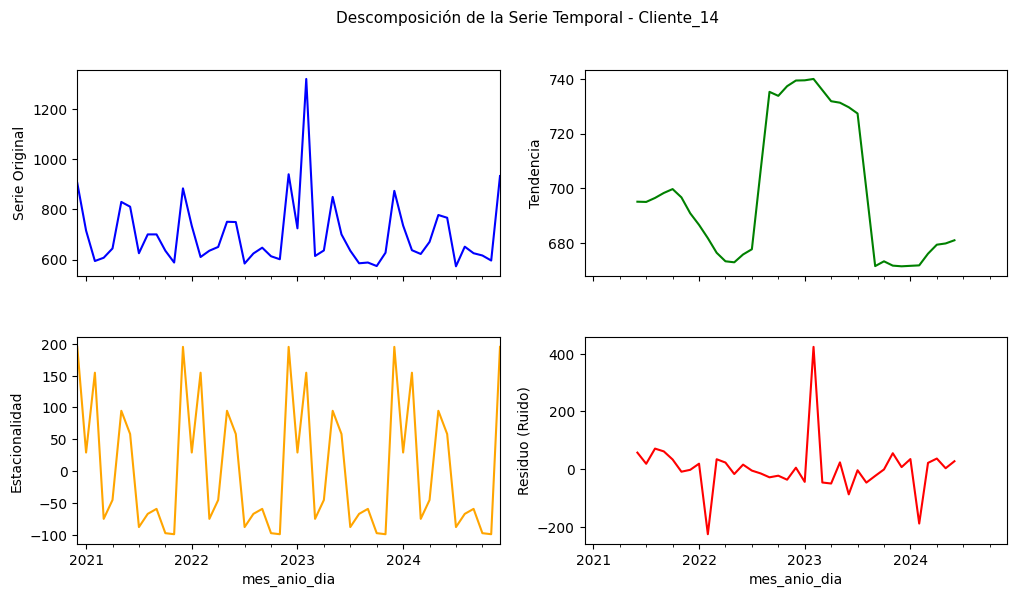

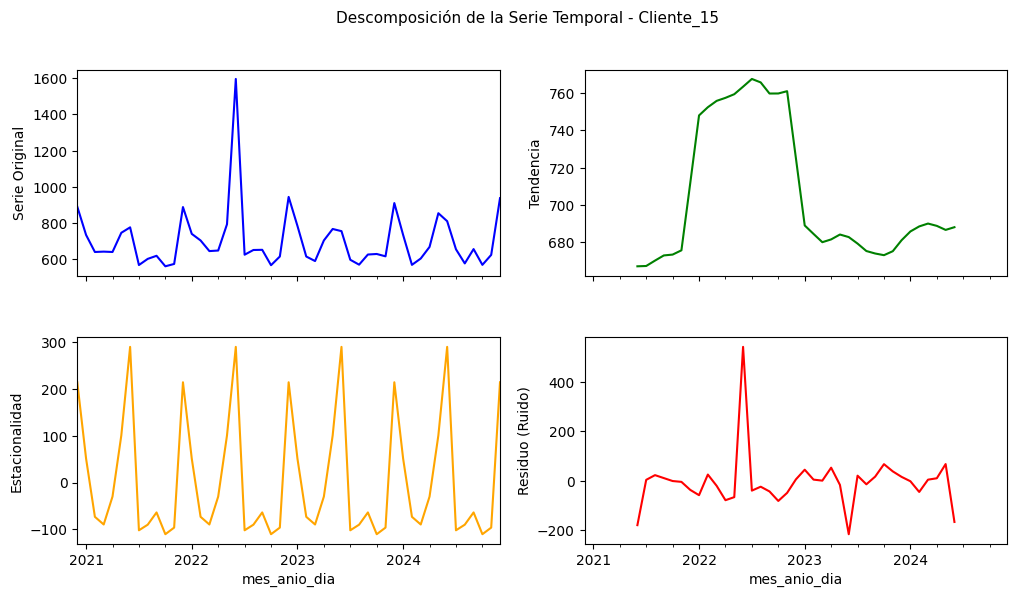

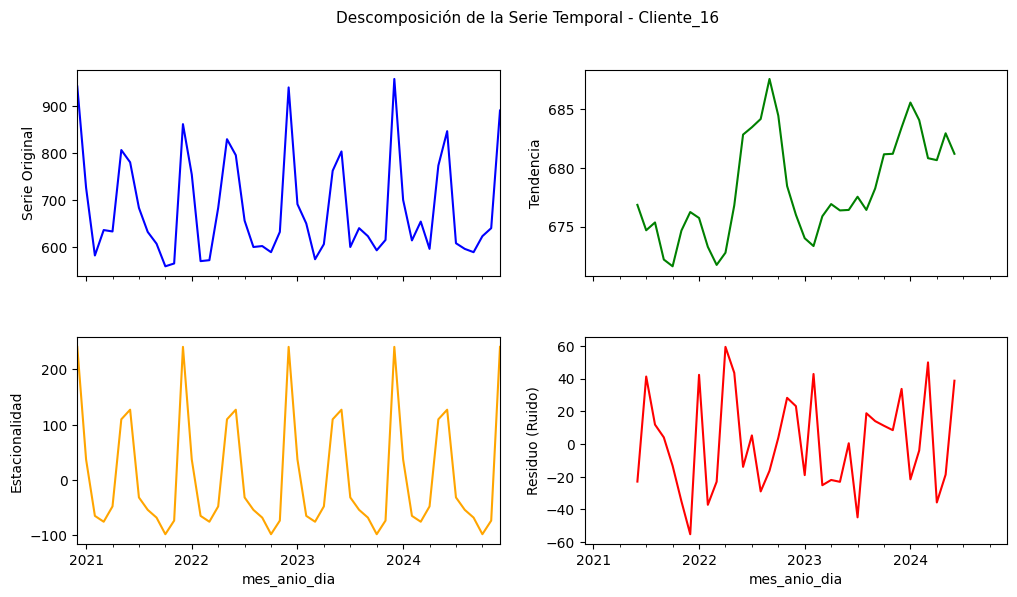

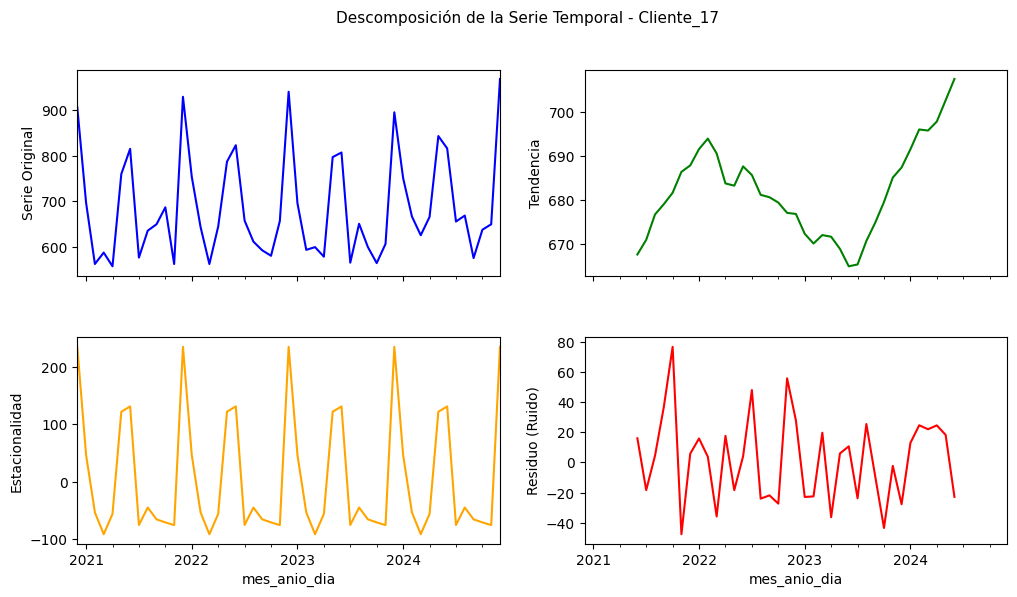

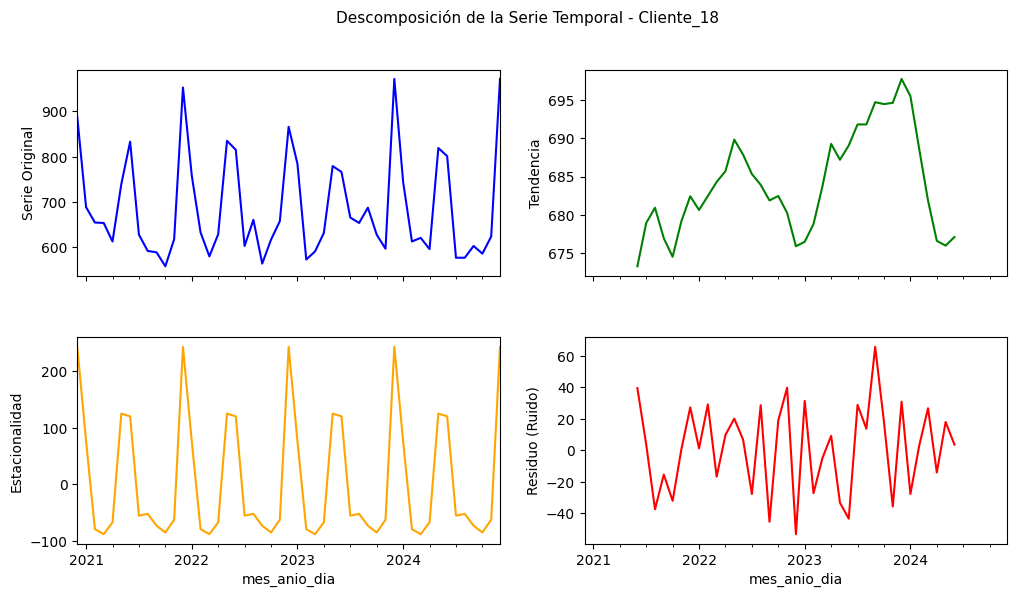

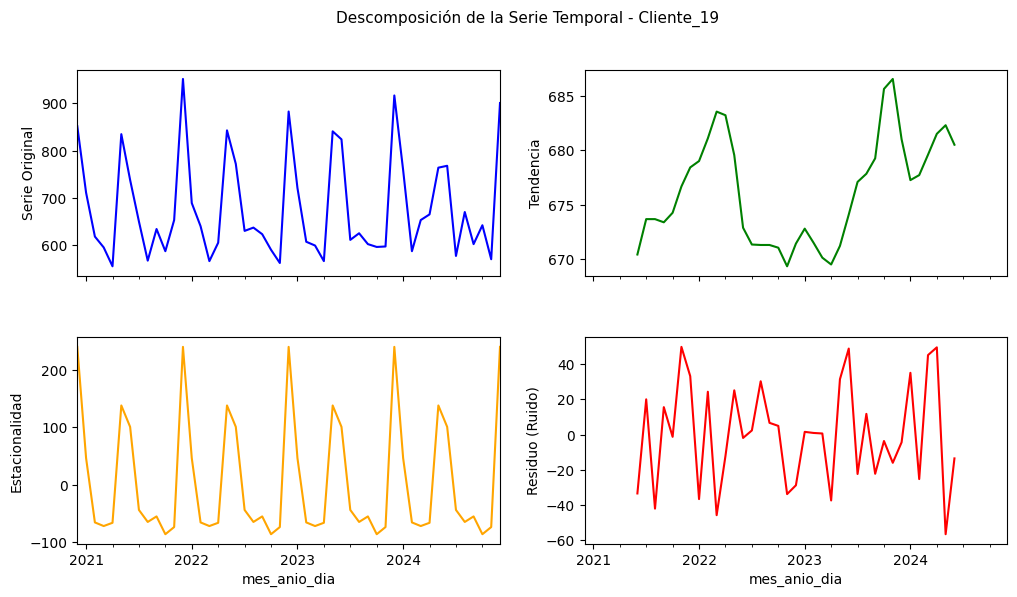

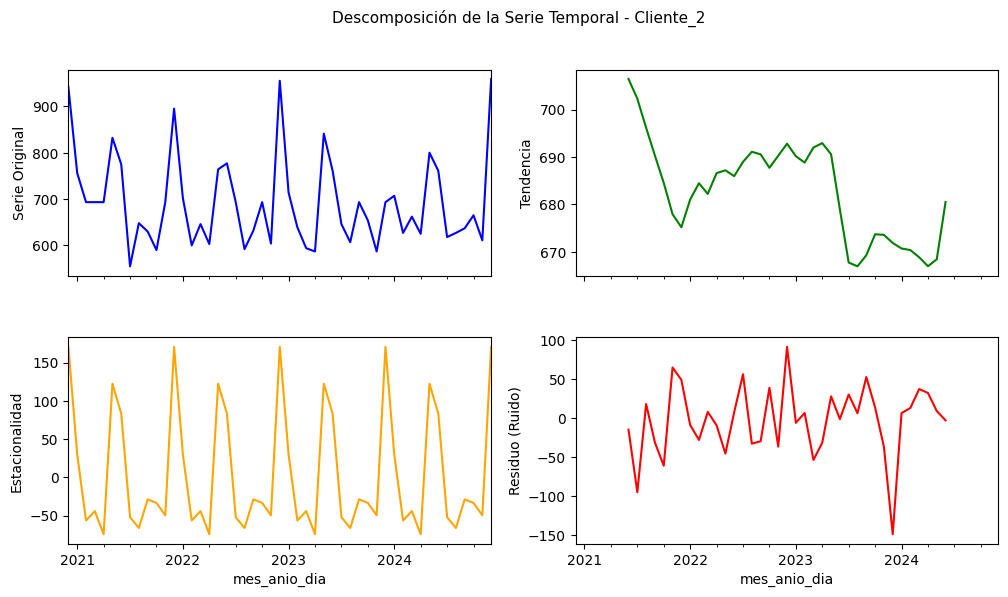

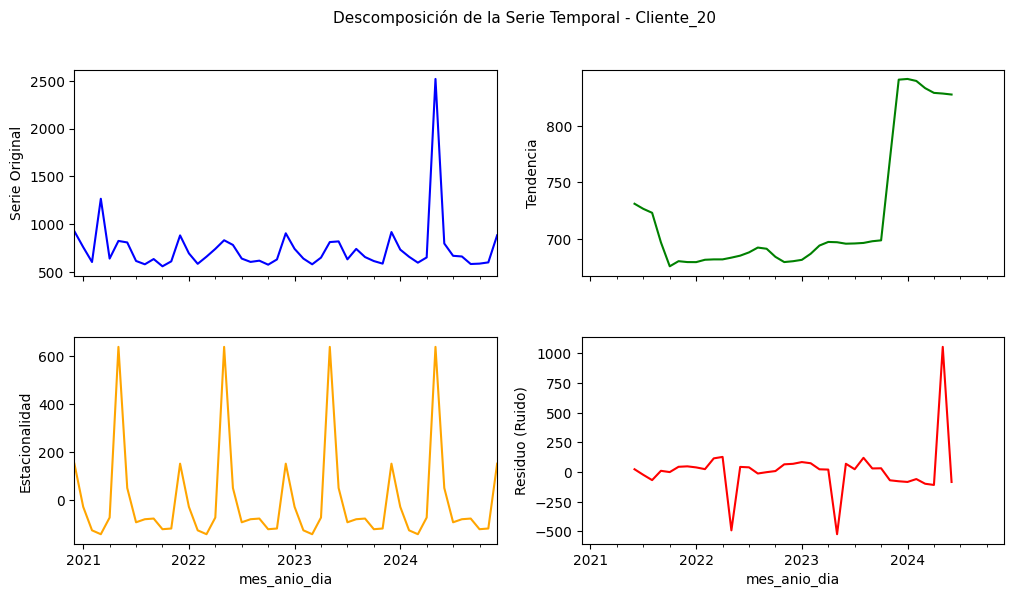

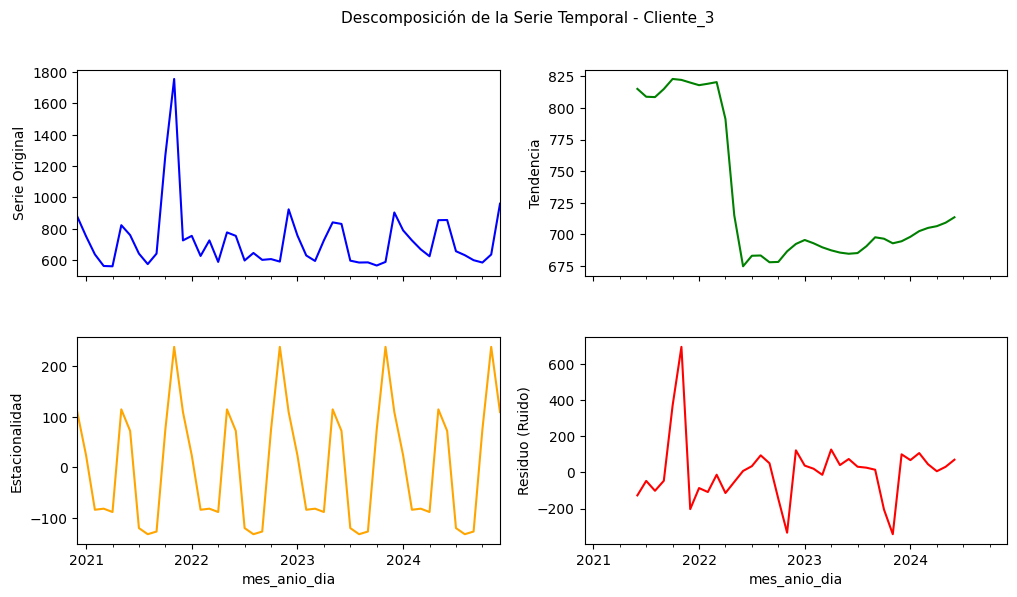

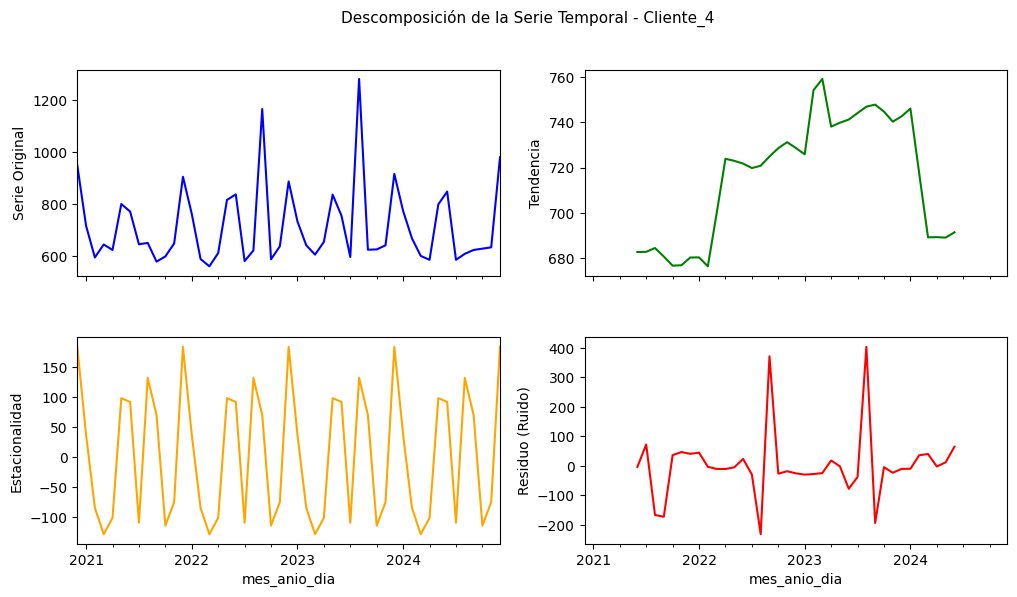

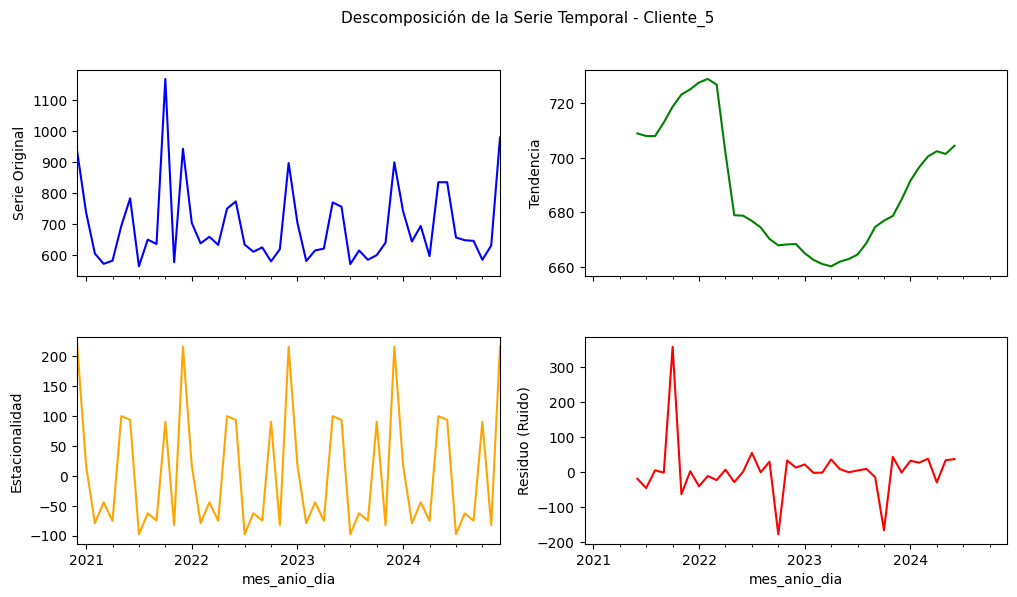

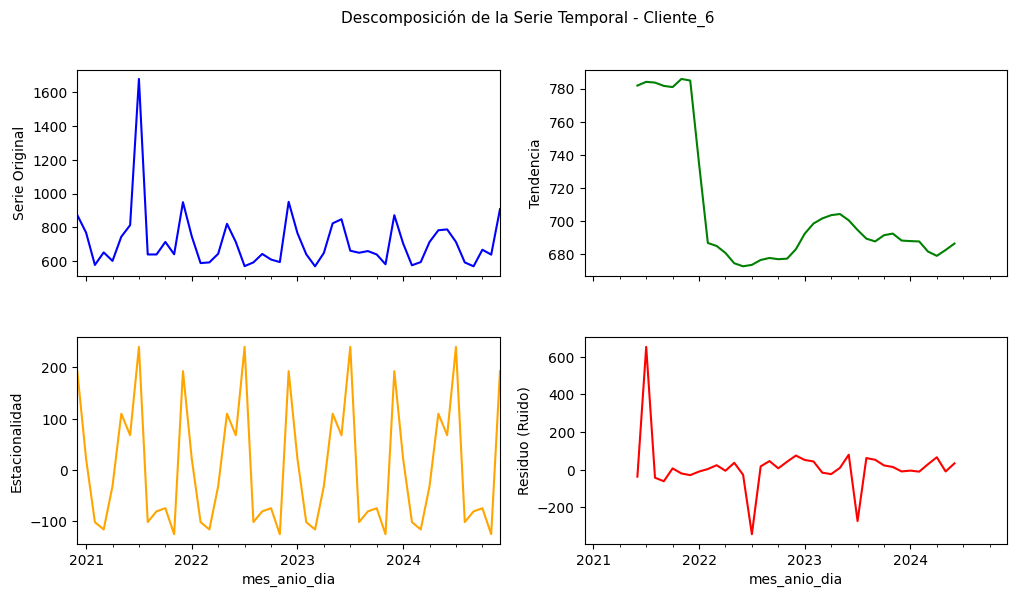

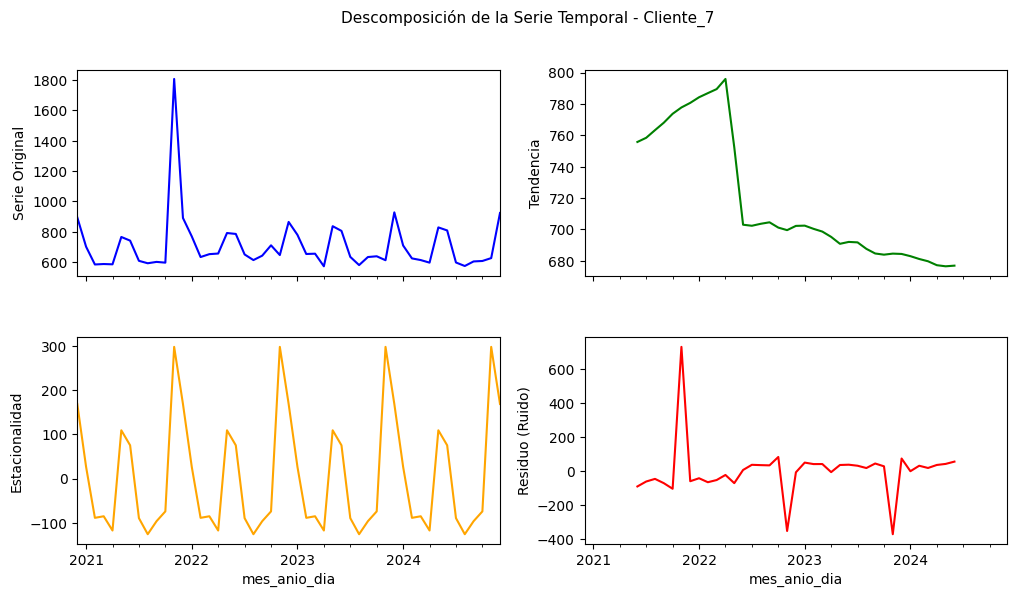

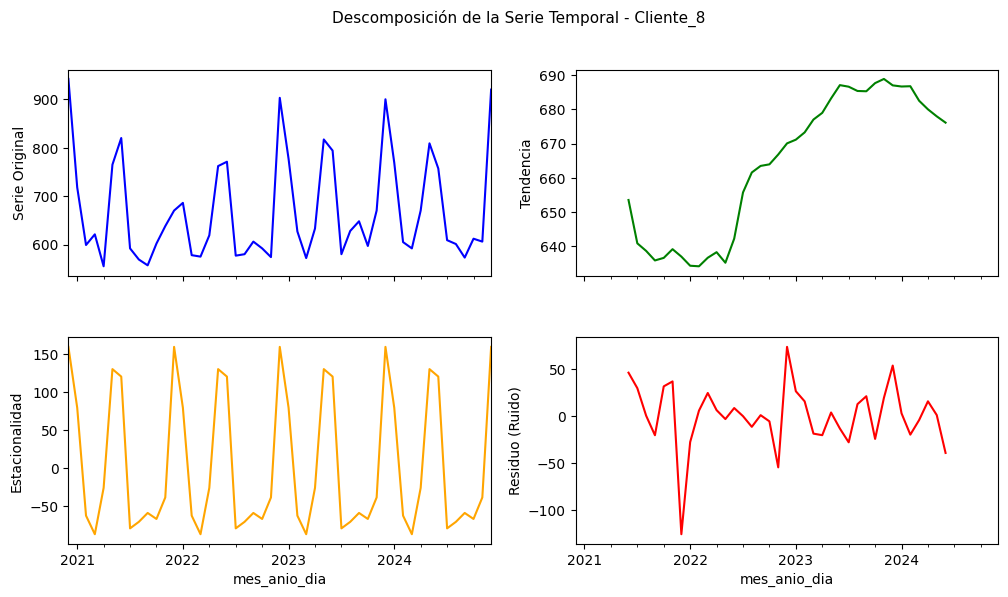

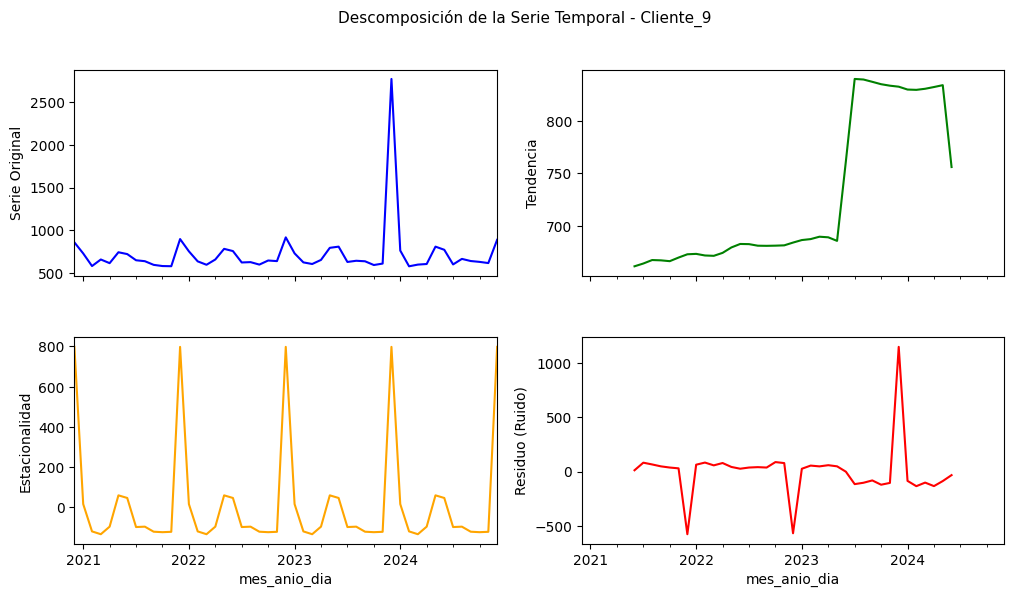

In [11]:
# Descomponer series temporales para cada cliente
for cliente, datos_cliente in clientes_data.items():
    # Establecer la fecha como índice
    datos_cliente = datos_cliente.set_index('mes_anio_dia')

    # Aplicar descomposición estacional (modelo aditivo, periodicidad anual)
    decomposition = seasonal_decompose(datos_cliente['order_demand'], model='additive', period=12)

    # Graficar los componentes en 2x2
    fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
    
    decomposition.observed.plot(ax=axes[0, 0], color='blue')
    decomposition.trend.plot(ax=axes[0, 1], color='green')
    decomposition.seasonal.plot(ax=axes[1, 0], color='orange')
    decomposition.resid.plot(ax=axes[1, 1], color='red')

    # Colocar títulos en el lateral izquierdo de cada gráfico
    axes[0, 0].set_ylabel("Serie Original", fontsize=10)
    axes[0, 1].set_ylabel("Tendencia", fontsize=10)
    axes[1, 0].set_ylabel("Estacionalidad", fontsize=10)
    axes[1, 1].set_ylabel("Residuo (Ruido)", fontsize=10)

    # Ajustar título general y evitar superposición
    plt.suptitle(f"Descomposición de la Serie Temporal - {cliente}", fontsize=11, y=1)
    plt.subplots_adjust(top=0.90, hspace=0.3)  # Ajustar espaciado

    plt.show()


2. Correlaciones

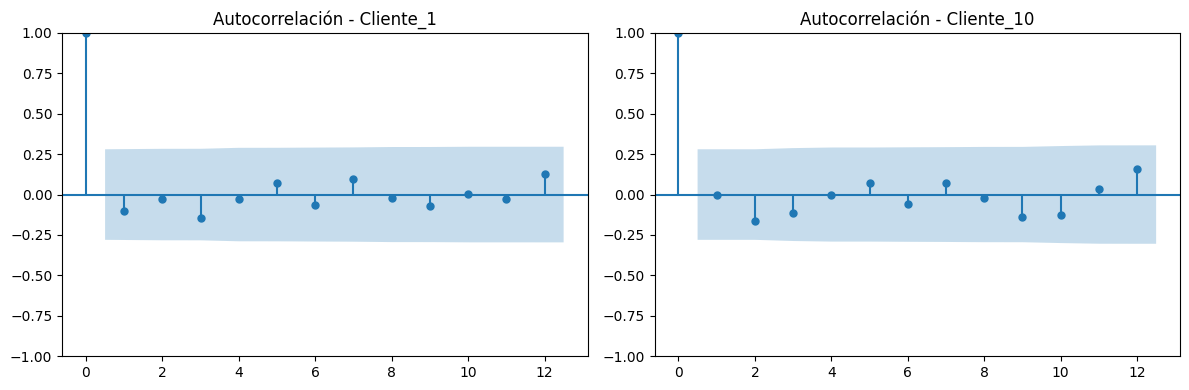

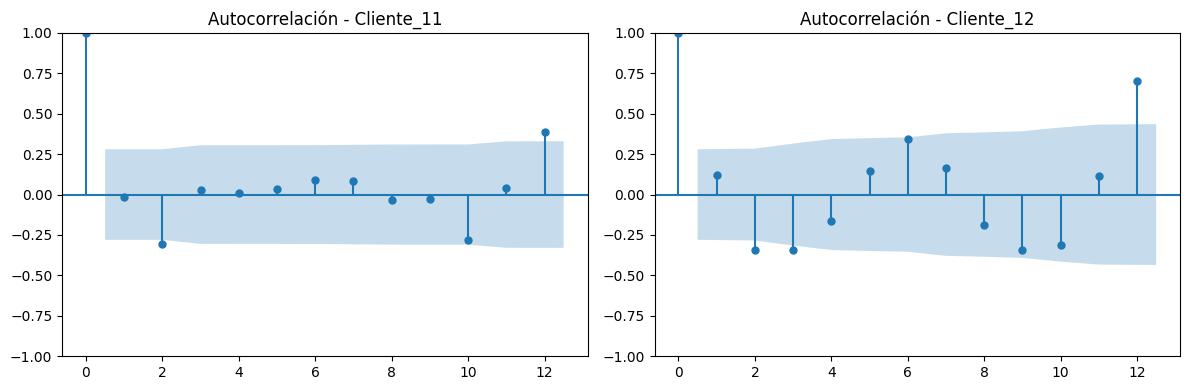

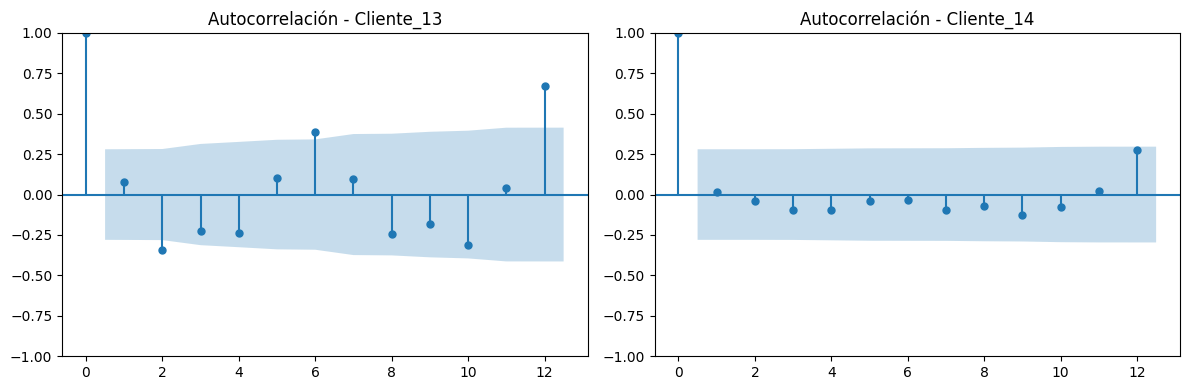

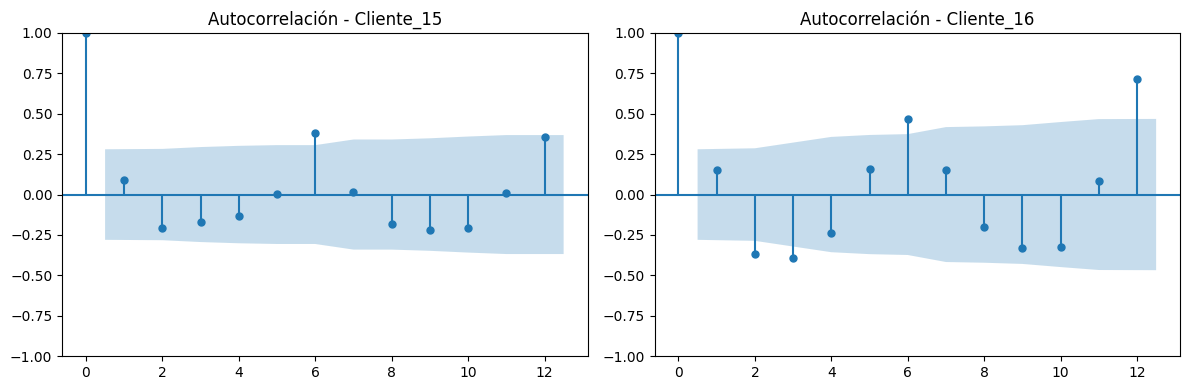

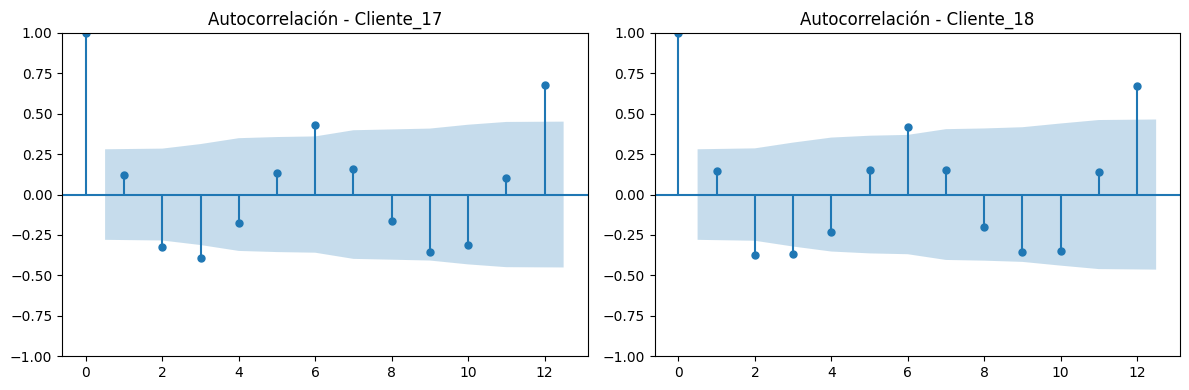

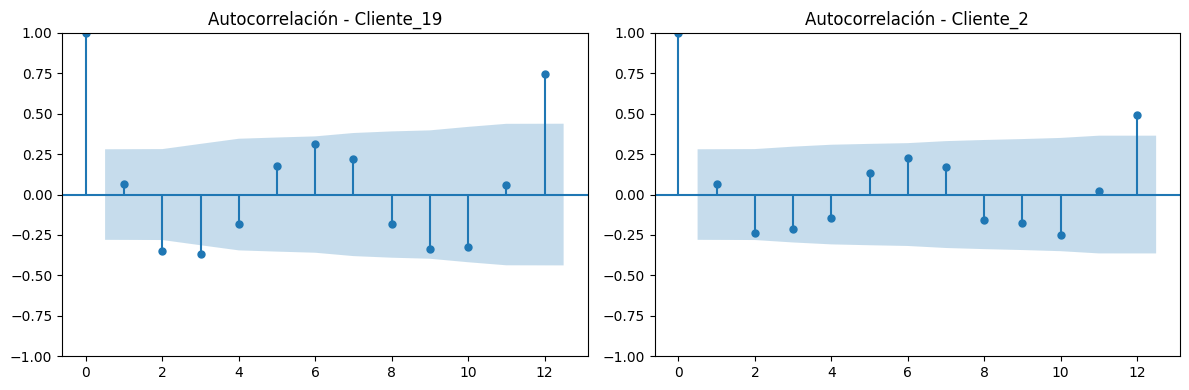

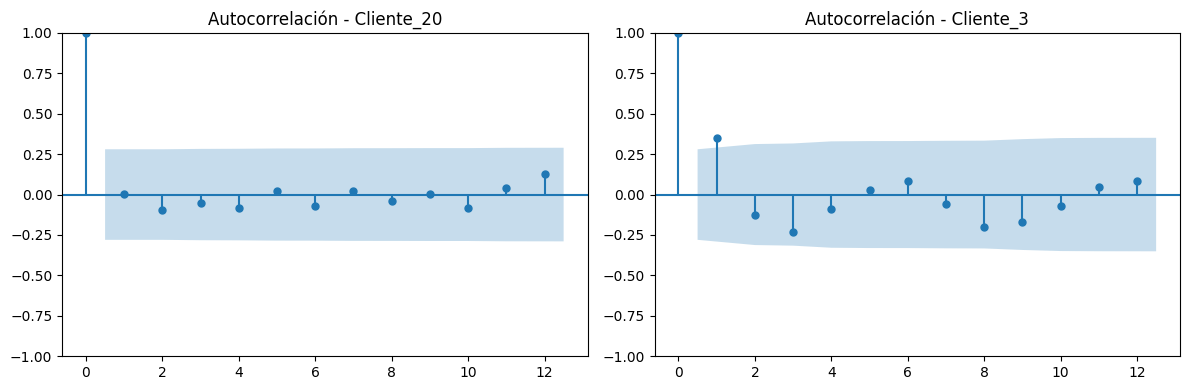

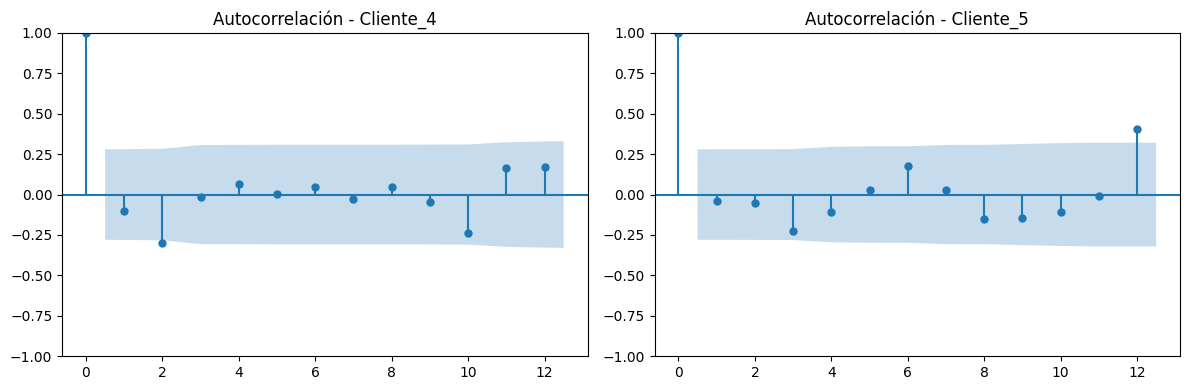

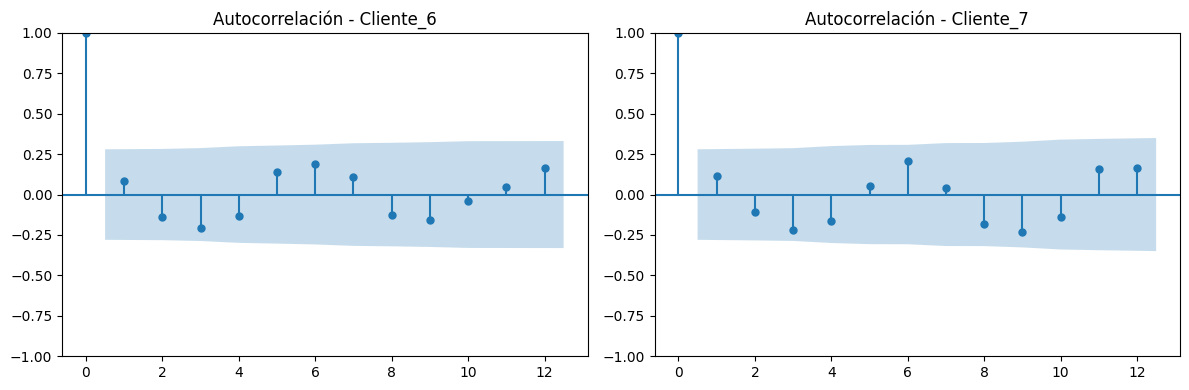

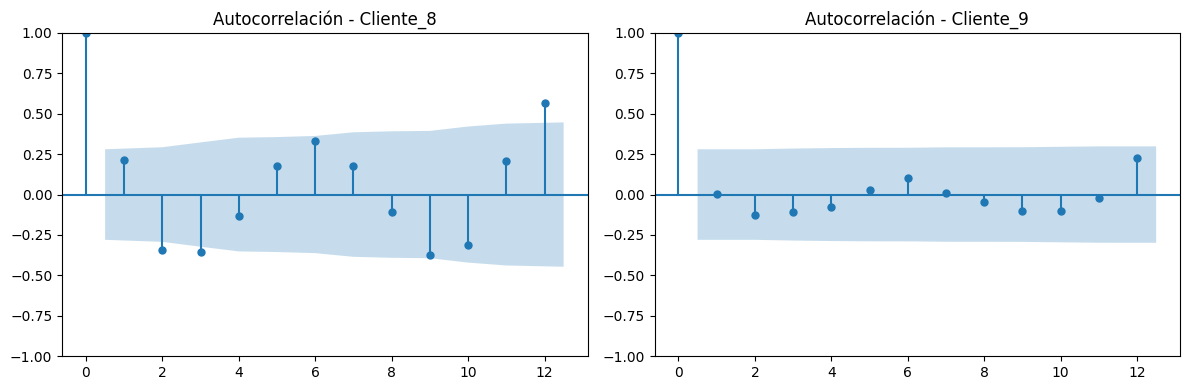

In [12]:
# Correlaciones
clientes = list(clientes_data.keys())  # Obtener la lista de clientes
num_clientes = len(clientes)

# Iterar de dos en dos para mostrar dos gráficos por fila
for i in range(0, num_clientes, 2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 fila, 2 columnas

    for j in range(2):  # Para cada columna en la fila
        if i + j < num_clientes:  # Verificar que hay datos suficientes
            cliente = clientes[i + j]
            df = clientes_data[cliente]

            plot_acf(df['order_demand'], lags=12, ax=axes[j])  # Autocorrelación
            axes[j].set_title(f"Autocorrelación - {cliente}")

    plt.tight_layout()
    plt.show()

2. Identificar Tendencias Globales

3. Análisis de Estacionalidad por Cliente

4. Evaluación de Estacionalidad y Ruido

Modelo de Predicción con Regresión Random Forest

In [13]:
# Paso 1: Importar las librerías necesarias
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [14]:
# Paso 2: Verificar la estructura de datos de un cliente

# Seleccionar un cliente de ejemplo para verificar estructura de datos
cliente_ejemplo = list(clientes_data.keys())[0]
df = clientes_data[cliente_ejemplo]

# Mostrar estructura del DataFrame
print(f"Cliente seleccionado: {cliente_ejemplo}")
print(df.head())
print("\nInformación del DataFrame:")
print(df.info())

Cliente seleccionado: Cliente_1
     cliente mes_anio  order_demand mes_anio_dia
0  Cliente_1  12-2020         857.0   2020-12-01
1  Cliente_1  01-2021         768.0   2021-01-01
2  Cliente_1  02-2021         635.0   2021-02-01
3  Cliente_1  03-2021         631.0   2021-03-01
4  Cliente_1  04-2021         589.0   2021-04-01

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 49 entries, 0 to 48
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   cliente       49 non-null     object        
 1   mes_anio      49 non-null     object        
 2   order_demand  49 non-null     float64       
 3   mes_anio_dia  49 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 1.9+ KB
None


In [15]:
# Paso 3: Crear características de series temporales para la predicción

def create_lag_features(df, target_column, lags=12):
    """
    Crea características de rezago (lags) en la serie temporal.

    Args:
        df (DataFrame): DataFrame con los datos de la serie temporal.
        target_column (str): Nombre de la columna objetivo.
        lags (int): Número de lags a generar.

    Returns:
        DataFrame: DataFrame con columnas adicionales de lags.
    """
    df = df.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_column].shift(lag)

    return df.dropna()  # Eliminar filas con NaN generadas por el shift

# Aplicar la transformación al DataFrame del cliente de ejemplo
df_lags = create_lag_features(df, target_column='order_demand', lags=12)

# Mostrar las primeras filas para verificar la transformación
print(df_lags.head())


      cliente mes_anio  order_demand mes_anio_dia  lag_1   lag_2   lag_3  \
12  Cliente_1  12-2021         886.0   2021-12-01  597.0  1848.0   589.0   
13  Cliente_1  01-2022         699.0   2022-01-01  886.0   597.0  1848.0   
14  Cliente_1  02-2022         609.0   2022-02-01  699.0   886.0   597.0   
15  Cliente_1  03-2022         633.0   2022-03-01  609.0   699.0   886.0   
16  Cliente_1  04-2022         563.0   2022-04-01  633.0   609.0   699.0   

     lag_4   lag_5   lag_6  lag_7  lag_8  lag_9  lag_10  lag_11  lag_12  
12   570.0   599.0   798.0  785.0  589.0  631.0   635.0   768.0   857.0  
13   589.0   570.0   599.0  798.0  785.0  589.0   631.0   635.0   768.0  
14  1848.0   589.0   570.0  599.0  798.0  785.0   589.0   631.0   635.0  
15   597.0  1848.0   589.0  570.0  599.0  798.0   785.0   589.0   631.0  
16   886.0   597.0  1848.0  589.0  570.0  599.0   798.0   785.0   589.0  


In [18]:
# Paso 4: Aplicar la transformación de datos para entrenamiento

# Definir el número de lags a considerar
num_lags = 12

# Aplicar la función de transformación al DataFrame del cliente de ejemplo
df_lags = create_lag_features(df, target_column='order_demand', lags=num_lags)

# Asegurar que no haya columnas no numéricas en X
columnas_a_eliminar = ['order_demand', 'cliente', 'mes_anio', 'mes_anio_dia']

# Separar características (X) y variable objetivo (y)
X = df_lags.drop(columns=[col for col in columnas_a_eliminar if col in df_lags.columns], errors='ignore')
X = X.select_dtypes(include=[np.number])  # Mantener solo columnas numéricas
y = df_lags['order_demand']

# Verificar la estructura de los datos transformados
print("Columnas de X después de la limpieza:\n", X.columns)


Columnas de X después de la limpieza:
 Index(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'lag_9', 'lag_10', 'lag_11', 'lag_12'],
      dtype='object')


In [19]:
# Paso 5: Dividir los datos en entrenamiento y prueba

# Dividir en conjunto de entrenamiento y prueba (sin mezclar los datos)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Verificar las dimensiones de los conjuntos
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


X_train shape: (29, 12), X_test shape: (8, 12)
y_train shape: (29,), y_test shape: (8,)


In [20]:
# Paso 6: Optimización de Hiperparámetros con GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Definir el modelo base
rf_model = RandomForestRegressor(random_state=42)

# Definir los hiperparámetros a buscar
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árboles en el bosque
    'max_depth': [None, 10, 20],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimo número de muestras requeridas en un nodo hoja
    'max_features': ['sqrt', 'log2'],  # Características válidas
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],  # Criterios para la función de pérdida
    'bootstrap': [True, False],  # Si se debe usar bootstrap
}

# Configurar GridSearchCV con validación cruzada de 3 folds
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Minimizar el error cuadrático medio
    cv=3,
    verbose=1,
    n_jobs=-1  # Paralelizar la búsqueda
)

# Ajustar el GridSearch a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y el modelo entrenado
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

print("\nMejores Hiperparámetros encontrados:", best_params)


Fitting 3 folds for each of 1296 candidates, totalling 3888 fits

Mejores Hiperparámetros encontrados: {'bootstrap': False, 'criterion': 'poisson', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


In [68]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

resultados_rf = {}

for cliente, df_cliente in clientes_data.items():
    try:
        # Crear las características de series temporales
        df_lags = create_lag_features(df_cliente, target_column='order_demand', lags=12)
        
        # Separar X e y
        columnas_a_eliminar = ['order_demand', 'cliente', 'mes_anio', 'mes_anio_dia']
        X = df_lags.drop(columns=[col for col in columnas_a_eliminar if col in df_lags.columns], errors='ignore')
        X = X.select_dtypes(include=[np.number])  # Asegurar solo columnas numéricas
        y = df_lags['order_demand']

        # Dividir en entrenamiento y prueba (sin mezcla)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        # Asegurar que las columnas coinciden
        X_test = X_test[X_train.columns]

        # Entrenar modelo
        best_rf_model.fit(X_train, y_train)

        # Hacer predicción
        y_pred = best_rf_model.predict(X_test)

        # Calcular métricas
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # Guardar resultados
        resultados_rf[cliente] = {
            'RMSE_RF': rmse,
            'MAE_RF': mae,
            'MSE_RF': mse,
            'R2_RF': r2
        }

    except Exception as e:
        print(f"Error en cliente {cliente}: {e}")
        continue

# Convertir resultados a DataFrame
df_resultados_rf = pd.DataFrame(resultados_rf).T
print(df_resultados_rf)


               RMSE_RF      MAE_RF         MSE_RF     R2_RF
Cliente_1    59.427019   46.232778    3531.570635  0.677885
Cliente_10  133.178616   86.131830   17736.543719 -0.499112
Cliente_11  184.940483   96.866219   34202.982154  0.151970
Cliente_12   52.420521   39.344601    2747.910988  0.826728
Cliente_13   52.308308   45.820066    2736.159135  0.823407
Cliente_14   53.796630   43.549357    2894.077396  0.780802
Cliente_15   68.307705   58.901689    4665.942555  0.719703
Cliente_16   46.617502   41.961318    2173.191518  0.832383
Cliente_17   49.409557   42.978819    2441.304371  0.843147
Cliente_18   68.297529   63.620208    4664.552501  0.763208
Cliente_19   59.001767   53.021319    3481.208453  0.702504
Cliente_2    72.951702   40.491789    5321.950789  0.595325
Cliente_20  628.143774  250.456534  394564.600877 -0.037697
Cliente_3    94.309480   74.478273    8894.278078  0.511504
Cliente_4   176.323511  128.676111   31089.980473 -0.703047
Cliente_5    66.818769   51.761281    44

Predicción

       Cliente  Predicción Order_Demand
0    Cliente_1                   822.04
1   Cliente_10                   687.34
2   Cliente_11                   739.07
3   Cliente_12                   747.67
4   Cliente_13                   853.67
5   Cliente_14                   764.43
6   Cliente_15                   745.31
7   Cliente_16                   748.32
8   Cliente_17                   727.99
9   Cliente_18                   777.86
10  Cliente_19                   798.82
11   Cliente_2                   718.32
12  Cliente_20                   784.46
13   Cliente_3                   837.09
14   Cliente_4                   749.28
15   Cliente_5                   783.79
16   Cliente_6                   707.82
17   Cliente_7                   760.40
18   Cliente_8                   743.96
19   Cliente_9                   795.62


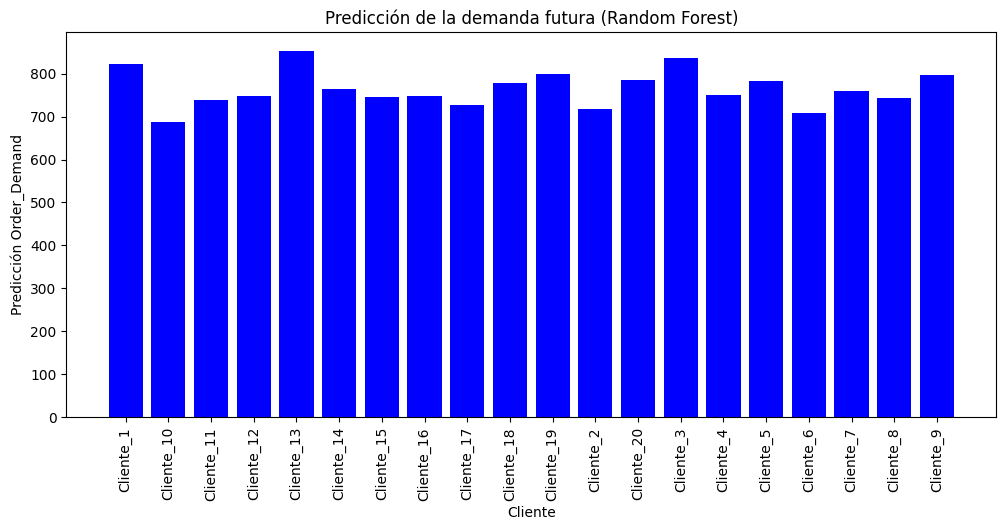

In [88]:
# Diccionario para almacenar las predicciones de cada cliente
predicciones = {}

# Iterar sobre cada cliente en el diccionario de datos
for cliente, df_cliente in clientes_data.items():
    # Asegurar que el DataFrame está ordenado por fecha
    df_cliente = df_cliente.sort_values(by='mes_anio_dia')

    # Seleccionar la última fila para obtener los valores de lag
    ultima_fila = df_cliente.iloc[-1]

    # Construir un DataFrame con una sola fila para la predicción
    X_nueva = pd.DataFrame({
        'lag_1': [ultima_fila['order_demand']],
        'lag_2': [df_cliente.iloc[-2]['order_demand'] if len(df_cliente) > 1 else ultima_fila['order_demand']],
        'lag_3': [df_cliente.iloc[-3]['order_demand'] if len(df_cliente) > 2 else ultima_fila['order_demand']],
        'lag_4': [df_cliente.iloc[-4]['order_demand'] if len(df_cliente) > 3 else ultima_fila['order_demand']],
        'lag_5': [df_cliente.iloc[-5]['order_demand'] if len(df_cliente) > 4 else ultima_fila['order_demand']],
        'lag_6': [df_cliente.iloc[-6]['order_demand'] if len(df_cliente) > 5 else ultima_fila['order_demand']],
        'lag_7': [df_cliente.iloc[-7]['order_demand'] if len(df_cliente) > 6 else ultima_fila['order_demand']],
        'lag_8': [df_cliente.iloc[-8]['order_demand'] if len(df_cliente) > 7 else ultima_fila['order_demand']],
        'lag_9': [df_cliente.iloc[-9]['order_demand'] if len(df_cliente) > 8 else ultima_fila['order_demand']],
        'lag_10': [df_cliente.iloc[-10]['order_demand'] if len(df_cliente) > 9 else ultima_fila['order_demand']],
        'lag_11': [df_cliente.iloc[-11]['order_demand'] if len(df_cliente) > 10 else ultima_fila['order_demand']],
        'lag_12': [df_cliente.iloc[-12]['order_demand'] if len(df_cliente) > 11 else ultima_fila['order_demand']]
    })

    # Usar el modelo para predecir la demanda del siguiente mes
    prediccion = best_rf_model.predict(X_nueva)[0]

    # Guardar la predicción en el diccionario
    predicciones[cliente] = prediccion

# Convertir a DataFrame para visualizar
df_predicciones_rf = pd.DataFrame(list(predicciones.items()), columns=['Cliente', 'Predicción Order_Demand'])
print(df_predicciones_rf)

# Gráfico de predicciones
plt.figure(figsize=(12, 5))
plt.bar(df_predicciones_rf['Cliente'], df_predicciones_rf['Predicción Order_Demand'], color='blue')
plt.xticks(rotation=90)
plt.xlabel("Cliente")
plt.ylabel("Predicción Order_Demand")
plt.title("Predicción de la demanda futura (Random Forest)")
plt.show()

In [ ]:
# Guardar las predicciones en un archivo CSV (opcional)
df_predicciones.to_csv("predicciones_random_forest.csv", index=False)
print("\nPredicciones guardadas en 'predicciones_random_forest.csv'.")

Modelo de ARIMA

In [23]:
# Importat librerías
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")  # Ignorar advertencias para simplificar la salida

In [24]:
# Paso 1: Verificar estructura del DataFrame
df_historicod_time.info()
df_historicod_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   cliente       980 non-null    object        
 1   mes_anio      980 non-null    object        
 2   order_demand  980 non-null    float64       
 3   mes_anio_dia  980 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 30.8+ KB


cliente mes_anio  order_demand mes_anio_dia
0  Cliente_1  12-2020         857.0   2020-12-01
1  Cliente_1  01-2021         768.0   2021-01-01
2  Cliente_1  02-2021         635.0   2021-02-01
3  Cliente_1  03-2021         631.0   2021-03-01
4  Cliente_1  04-2021         589.0   2021-04-01

In [25]:
# Paso 2: Verificar Estacionariedad para todos los clientes
resultados_estacionariedad = {}
clientes_estacionarios = []
clientes_no_estacionarios = []

for cliente, data_cliente in clientes_data.items():
    # Seleccionar solo la columna de demanda y ordenar por fecha
    data_cliente = data_cliente[['mes_anio_dia', 'order_demand']].set_index('mes_anio_dia').sort_index()

    # Prueba ADF (Dickey-Fuller Aumentada)
    result_adf = adfuller(data_cliente['order_demand'])
    p_valor = result_adf[1]  # Extraemos el p-valor para verificar la estacionariedad

    # Guardar resultados
    es_estacionaria = p_valor <= 0.05
    resultados_estacionariedad[cliente] = {
        'es_estacionaria': es_estacionaria,
        'p_valor': p_valor,
        'estadistico_adf': result_adf[0],
        'razon': 'Serie estacionaria' if es_estacionaria else 'p-valor > 0.05, no estacionaria'
    }

    # Clasificar correctamente los clientes
    if es_estacionaria:
        clientes_estacionarios.append(cliente)
    else:
        clientes_no_estacionarios.append(cliente)

# Resumen final
print("\nClientes con series estacionarias:")
print(clientes_estacionarios)

print("\nClientes con series no estacionarias:")
print(clientes_no_estacionarios)

# Verificación adicional
print("\nResumen detallado de la prueba Dickey-Fuller:")
for cliente, info in resultados_estacionariedad.items():
    print(f"{cliente}: {info['razon']} (p-valor: {info['p_valor']:.4f})")



Clientes con series estacionarias:
['Cliente_1', 'Cliente_10', 'Cliente_14', 'Cliente_15', 'Cliente_20', 'Cliente_3', 'Cliente_4', 'Cliente_6', 'Cliente_7', 'Cliente_9']

Clientes con series no estacionarias:
['Cliente_11', 'Cliente_12', 'Cliente_13', 'Cliente_16', 'Cliente_17', 'Cliente_18', 'Cliente_19', 'Cliente_2', 'Cliente_5', 'Cliente_8']

Resumen detallado de la prueba Dickey-Fuller:
Cliente_1: Serie estacionaria (p-valor: 0.0000)
Cliente_10: Serie estacionaria (p-valor: 0.0000)
Cliente_11: p-valor > 0.05, no estacionaria (p-valor: 0.9840)
Cliente_12: p-valor > 0.05, no estacionaria (p-valor: 0.8394)
Cliente_13: p-valor > 0.05, no estacionaria (p-valor: 0.6173)
Cliente_14: Serie estacionaria (p-valor: 0.0000)
Cliente_15: Serie estacionaria (p-valor: 0.0000)
Cliente_16: p-valor > 0.05, no estacionaria (p-valor: 0.2869)
Cliente_17: p-valor > 0.05, no estacionaria (p-valor: 0.8727)
Cliente_18: p-valor > 0.05, no estacionaria (p-valor: 0.1637)
Cliente_19: p-valor > 0.05, no estacio

In [26]:
# Paso 3:
# Aplicar diferenciación a las series no estacionarias
clientes_a_diferenciar = clientes_no_estacionarios.copy()
clientes_a_reintentar = []  # Para los clientes que aún no sean estacionarios tras d=1

print("\nResultados de la prueba ADF después de la diferenciación:")

for cliente in clientes_a_diferenciar:
    # Aplicar diferenciación de primer orden (d=1)
    clientes_data[cliente]['order_demand_diff1'] = clientes_data[cliente]['order_demand'].diff().dropna()
    result_adf_diff1 = adfuller(clientes_data[cliente]['order_demand_diff1'].dropna())
    
    # Evaluar si con d=1 la serie ya es estacionaria
    if result_adf_diff1[1] <= 0.05:
        print(f"{cliente} | d=1 | p-valor: {result_adf_diff1[1]:.4f} | Estacionaria")
    else:
        clientes_a_reintentar.append(cliente)
        print(f"{cliente} | d=1 | p-valor: {result_adf_diff1[1]:.4f} | No estacionaria, se probará con d=2")

# Aplicar diferenciación de segundo orden (d=2) si es necesario
if clientes_a_reintentar:
    print("\nAplicando diferenciación de segundo orden (d=2) para clientes restantes...\n")
    for cliente in clientes_a_reintentar:
        # Aplicar diferenciación de segundo orden (d=2)
        clientes_data[cliente]['order_demand_diff2'] = clientes_data[cliente]['order_demand_diff1'].diff().dropna()
        result_adf_diff2 = adfuller(clientes_data[cliente]['order_demand_diff2'].dropna())

        # Evaluar si con d=2 la serie es estacionaria
        if result_adf_diff2[1] <= 0.05:
            print(f"{cliente} | d=2 | p-valor: {result_adf_diff2[1]:.4f} | Estacionaria")
        else:
            print(f"{cliente} | d=2 | p-valor: {result_adf_diff2[1]:.4f} | Aún no estacionaria")



Resultados de la prueba ADF después de la diferenciación:
Cliente_11 | d=1 | p-valor: 0.0138 | Estacionaria
Cliente_12 | d=1 | p-valor: 0.0000 | Estacionaria
Cliente_13 | d=1 | p-valor: 0.0000 | Estacionaria
Cliente_16 | d=1 | p-valor: 0.0000 | Estacionaria
Cliente_17 | d=1 | p-valor: 0.0000 | Estacionaria
Cliente_18 | d=1 | p-valor: 0.0000 | Estacionaria
Cliente_19 | d=1 | p-valor: 0.0000 | Estacionaria
Cliente_2 | d=1 | p-valor: 0.0001 | Estacionaria
Cliente_5 | d=1 | p-valor: 0.0000 | Estacionaria
Cliente_8 | d=1 | p-valor: 0.0001 | Estacionaria


In [27]:
# Asignar d_inicial
# Crear diccionario para almacenar el valor de d inicial
d_inicial_por_cliente = {}

# Asignar d=0 a los clientes que eran estacionarios desde el inicio
for cliente in clientes_estacionarios:
    d_inicial_por_cliente[cliente] = 0  

# Asignar d=1 a los clientes que requirieron diferenciación
for cliente in clientes_no_estacionarios:  # Es lo mismo que clientes_diferenciados
    d_inicial_por_cliente[cliente] = 1  

# Mostrar los valores asignados
print("Parámetro d inicial por cliente:")
for cliente, d in d_inicial_por_cliente.items():
    print(f"{cliente}: d={d}")


Parámetro d inicial por cliente:
Cliente_1: d=0
Cliente_10: d=0
Cliente_14: d=0
Cliente_15: d=0
Cliente_20: d=0
Cliente_3: d=0
Cliente_4: d=0
Cliente_6: d=0
Cliente_7: d=0
Cliente_9: d=0
Cliente_11: d=1
Cliente_12: d=1
Cliente_13: d=1
Cliente_16: d=1
Cliente_17: d=1
Cliente_18: d=1
Cliente_19: d=1
Cliente_2: d=1
Cliente_5: d=1
Cliente_8: d=1


In [57]:
# Paso 3:

# Diccionario para almacenar los mejores modelos
best_models = {}

# Rango de valores a probar para p, d y q
p_values = range(0, 3)  # p = 0,1,2
d_values = range(0, 3)  # d = 0,1,2 (evaluar todas las opciones)
q_values = range(0, 3)  # q = 0,1,2

# Iterar sobre cada cliente en clientes_data
for cliente, data_cliente in clientes_data.items():
    # print(f"\nProcesando cliente: {cliente}")

    # Seleccionar la serie temporal y ordenar por fecha
    series_to_use = data_cliente[['mes_anio_dia', 'order_demand']].set_index('mes_anio_dia').sort_index()
    series_to_use = series_to_use['order_demand'].dropna()

    # Asignar d mínimo según el análisis previo
    d_min = d_inicial_por_cliente[cliente]

    best_aic = np.inf
    best_order = None
    best_model = None

    # Probar combinaciones de parámetros p, d y q
    for d in d_values:
        if d < d_min:
            continue  # Saltar valores de d que no cumplen la mínima diferenciación

        for p in p_values:
            for q in q_values:
                try:
                    model = ARIMA(series_to_use, order=(p, d, q))
                    model_fit = model.fit()

                    # Evaluar AIC
                    aic = model_fit.aic

                    # Validación: Evitar modelos degenerados (como Cliente_20 con AIC=10.0)
                    if aic < 50:  
                        print(f"⚠️ AIC sospechosamente bajo ({aic}) para {cliente} con ARIMA({p},{d},{q}) - Modelo descartado")
                        continue

                    # Guardar el mejor modelo encontrado
                    if aic < best_aic:
                        best_aic = aic
                        best_order = (p, d, q)
                        best_model = model_fit
                except Exception:
                    continue  # Ignorar errores y continuar con la siguiente combinación

    # Almacenar el mejor modelo para este cliente
    best_models[cliente] = {
        'model': best_model,
        'order': best_order,
        'aic': best_aic
    }
    print(f"Mejor modelo para {cliente}: ARIMA{best_order} - AIC: {best_aic}")


Mejor modelo para Cliente_1: ARIMA(0, 2, 2) - AIC: 648.1341084730429
Mejor modelo para Cliente_10: ARIMA(0, 2, 2) - AIC: 677.5643292201984
Mejor modelo para Cliente_11: ARIMA(2, 2, 2) - AIC: 600.9641207726299
Mejor modelo para Cliente_12: ARIMA(2, 1, 2) - AIC: 588.0695511793515
Mejor modelo para Cliente_13: ARIMA(2, 1, 2) - AIC: 588.5811385739278
Mejor modelo para Cliente_14: ARIMA(0, 2, 2) - AIC: 613.8110961312653
Mejor modelo para Cliente_15: ARIMA(0, 2, 2) - AIC: 634.2665766100978
Mejor modelo para Cliente_16: ARIMA(2, 1, 2) - AIC: 576.0209308078336
Mejor modelo para Cliente_17: ARIMA(2, 1, 2) - AIC: 589.2778861253635
Mejor modelo para Cliente_18: ARIMA(2, 1, 2) - AIC: 583.1379070074023
Mejor modelo para Cliente_19: ARIMA(2, 1, 2) - AIC: 578.1261933111332
Mejor modelo para Cliente_2: ARIMA(0, 2, 2) - AIC: 583.3253642160191
⚠️ AIC sospechosamente bajo (10.0) para Cliente_20 con ARIMA(2,2,2) - Modelo descartado
Mejor modelo para Cliente_20: ARIMA(0, 2, 2) - AIC: 686.0246973247639
Mejo

           Mejor ARIMA         AIC     MAE        MSE    RMSE      R²
Cliente_1    (0, 2, 2)  648.134108   67.42    9650.26   98.24 -0.2206
Cliente_10   (0, 2, 2)  677.564329  105.31   16017.72  126.56 -0.6382
Cliente_11   (2, 2, 2)  600.964121  102.76   25530.64  159.78  0.1742
Cliente_12   (2, 1, 2)  588.069551   54.83    7777.72   88.19  0.4665
Cliente_13   (2, 1, 2)  588.581139   72.35     7985.9   89.36  0.3454
Cliente_14   (0, 2, 2)  613.811096   85.83   10547.29   102.7 -0.1008
Cliente_15   (0, 2, 2)  634.266577  101.54   14567.68   120.7 -0.0867
Cliente_16   (2, 1, 2)  576.020931   64.13    5885.27   76.72  0.4019
Cliente_17   (2, 1, 2)  589.277886   79.19   10393.86  101.95  0.1049
Cliente_18   (2, 1, 2)  583.137907   77.97    9221.52   96.03  0.3806
Cliente_19   (2, 1, 2)  578.126193   63.22    7106.06    84.3  0.2235
Cliente_2    (0, 2, 2)  583.325364   73.08   10479.07  102.37 -0.0696
Cliente_20   (0, 2, 2)  686.024697  259.45  306254.87   553.4 -0.1407
Cliente_3    (0, 1, 

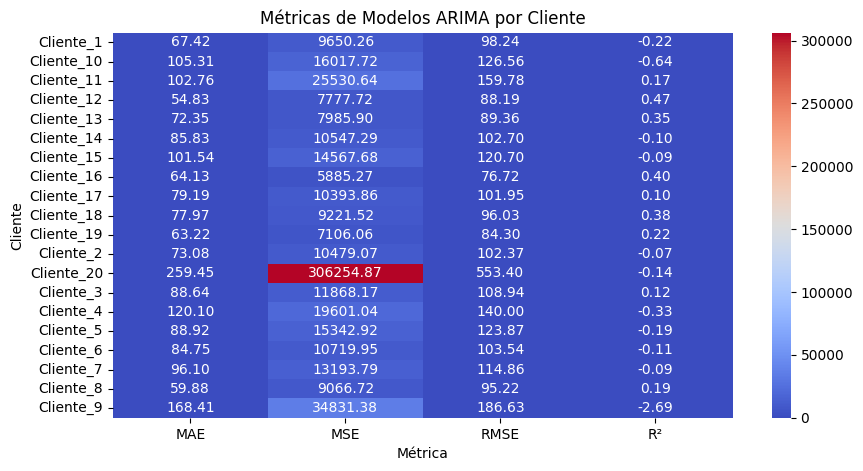

In [62]:
# Métricas 

# Diccionario para almacenar los resultados de las métricas
resultados_arima = {}

for cliente, info in best_models.items():
    modelo = info['model']  # Obtener el mejor modelo
    if modelo is None:
        print(f"No se encontró un modelo válido para {cliente}.")
        continue

    # Obtener datos originales del cliente
    data_cliente = clientes_data[cliente][['mes_anio_dia', 'order_demand']].set_index('mes_anio_dia').sort_index()

    # Definir datos de prueba y predicciones
    y_test = data_cliente['order_demand'].iloc[-12:]  # Últimos 12 valores como test
    y_pred = modelo.predict(start=len(data_cliente)-12, end=len(data_cliente)-1)

    # Calcular métricas
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Guardar resultados
    resultados_arima[cliente] = {
        'Mejor ARIMA': info['order'],
        'AIC': info['aic'],
        'MAE': round(mae, 2),
        'MSE': round(mse, 2),
        'RMSE': round(rmse, 2),
        'R²': round(r2, 4)
    }

# Convertir resultados a DataFrame para visualización
df_resultados_arima = pd.DataFrame(resultados_arima).T

# Mostrar las métricas como tabla
print(df_resultados_arima)

# Visualizar las métricas con heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(df_resultados_arima[['MAE', 'MSE', 'RMSE', 'R²']].astype(float), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Métricas de Modelos ARIMA por Cliente")
plt.xlabel("Métrica")
plt.ylabel("Cliente")
plt.show()


       Cliente  Predicción Order_Demand
0    Cliente_1                   654.11
1   Cliente_10                   754.86
2   Cliente_11                   854.42
3   Cliente_12                   725.27
4   Cliente_13                   765.33
5   Cliente_14                   691.54
6   Cliente_15                   691.24
7   Cliente_16                   745.91
8   Cliente_17                   754.90
9   Cliente_18                   825.57
10  Cliente_19                   734.08
11   Cliente_2                   687.45
12  Cliente_20                   774.12
13   Cliente_3                   841.01
14   Cliente_4                   721.47
15   Cliente_5                   690.10
16   Cliente_6                   682.83
17   Cliente_7                   664.78
18   Cliente_8                   819.57
19   Cliente_9                   782.38


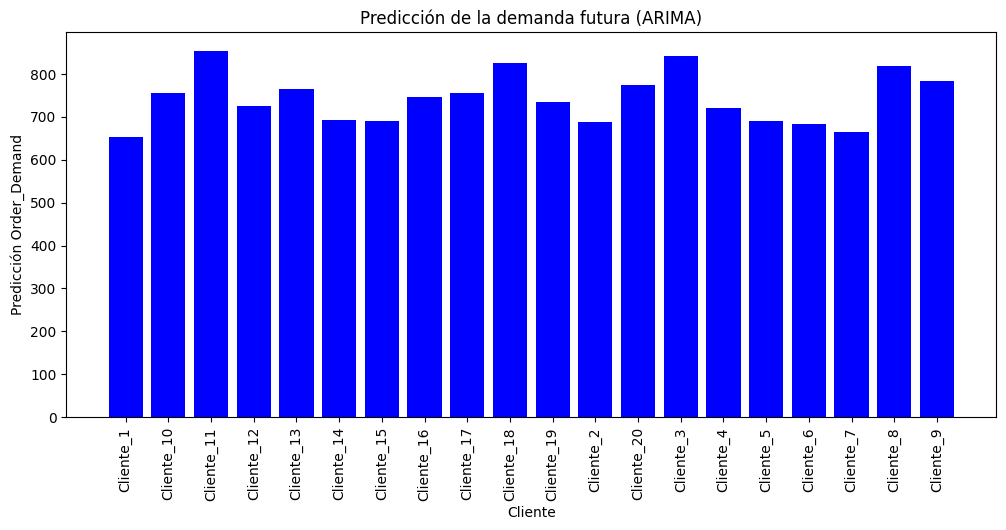

In [89]:
# Paso 4: Predicciones

# Diccionario para almacenar las predicciones
predicciones_arima = {}

# Período de predicción (predecir un mes en adelante)
num_periodos_prediccion = 1  

# Realizar predicciones con los mejores modelos ARIMA para cada cliente
for cliente, info in best_models.items():
    modelo = info['model']
    
    if modelo is not None:
        try:
            # Realizar predicción para el próximo mes
            prediccion = modelo.forecast(steps=num_periodos_prediccion)
            predicciones_arima[cliente] = prediccion.iloc[0]
        except Exception as e:
            predicciones_arima[cliente] = None
            print(f"Error al predecir para {cliente}: {e}")

# Convertir a DataFrame
df_predicciones_arima = pd.DataFrame(
    list(predicciones_arima.items()), 
    columns=['Cliente', 'Predicción Order_Demand']
)

# Visualizar predicciones en una tabla
print(df_predicciones_arima)

# Gráfico de predicciones
plt.figure(figsize=(12, 5))
plt.bar(df_predicciones_arima['Cliente'], df_predicciones_arima['Predicción Order_Demand'], color='blue')
plt.xticks(rotation=90)
plt.xlabel("Cliente")
plt.ylabel("Predicción Order_Demand")
plt.title("Predicción de la demanda futura (ARIMA)")
plt.show()


In [86]:
df_predicciones_arima


Cliente  Predicción Order_Demand
0    Cliente_1                   654.11
1   Cliente_10                   754.86
2   Cliente_11                   854.42
3   Cliente_12                   725.27
4   Cliente_13                   765.33
5   Cliente_14                   691.54
6   Cliente_15                   691.24
7   Cliente_16                   745.91
8   Cliente_17                   754.90
9   Cliente_18                   825.57
10  Cliente_19                   734.08
11   Cliente_2                   687.45
12  Cliente_20                   774.12
13   Cliente_3                   841.01
14   Cliente_4                   721.47
15   Cliente_5                   690.10
16   Cliente_6                   682.83
17   Cliente_7                   664.78
18   Cliente_8                   819.57
19   Cliente_9                   782.38

Comparación RMSE de ARIMA vs. Random Forest


📊 Comparación de Modelos (ARIMA vs Random Forest)

               RMSE_RF      MAE_RF         MSE_RF     R2_RF RMSE_ARIMA  \
Cliente_1    59.427019   46.232778    3531.570635  0.677885      98.24   
Cliente_10  133.178616   86.131830   17736.543719 -0.499112     126.56   
Cliente_11  184.940483   96.866219   34202.982154  0.151970     159.78   
Cliente_12   52.420521   39.344601    2747.910988  0.826728      88.19   
Cliente_13   52.308308   45.820066    2736.159135  0.823407      89.36   
Cliente_14   53.796630   43.549357    2894.077396  0.780802      102.7   
Cliente_15   68.307705   58.901689    4665.942555  0.719703      120.7   
Cliente_16   46.617502   41.961318    2173.191518  0.832383      76.72   
Cliente_17   49.409557   42.978819    2441.304371  0.843147     101.95   
Cliente_18   68.297529   63.620208    4664.552501  0.763208      96.03   
Cliente_19   59.001767   53.021319    3481.208453  0.702504       84.3   
Cliente_2    72.951702   40.491789    5321.950789  0.595325 

<Figure size 1200x600 with 0 Axes>

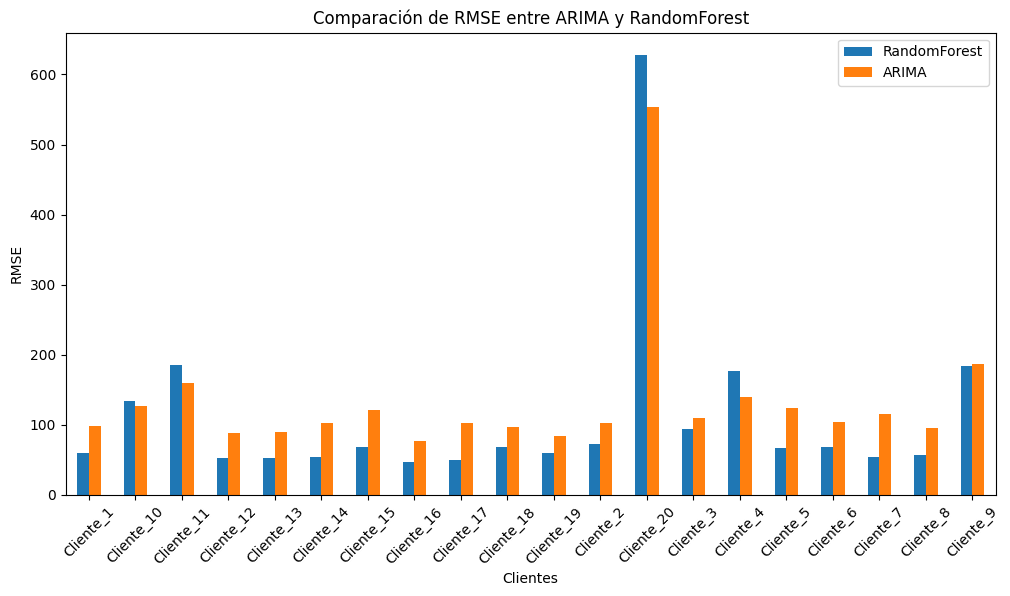

In [79]:


# Unir los resultados de ambos modelos para comparación
df_comparacion = df_resultados_rf.join(df_resultados_arima[['RMSE_ARIMA', 'MAE_ARIMA', 'MSE_ARIMA', 'R2_ARIMA']], how='inner')

# Comparación basada en RMSE (menor es mejor)
df_comparacion['Mejor_Modelo_RMSE'] = df_comparacion.apply(
    lambda row: 'ARIMA' if row['RMSE_ARIMA'] < row['RMSE_RF'] else 'RandomForest', axis=1
)

# Comparación basada en R² (mayor es mejor)
df_comparacion['Mejor_Modelo_R2'] = df_comparacion.apply(
    lambda row: 'ARIMA' if row['R2_ARIMA'] > row['R2_RF'] else 'RandomForest', axis=1
)

# Mostrar DataFrame en consola
print("\n📊 Comparación de Modelos (ARIMA vs Random Forest)\n")
print(df_comparacion)

# Graficar Comparación RMSE
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df_comparacion[['RMSE_RF', 'RMSE_ARIMA']].plot(kind='bar', figsize=(12,6))
plt.title("Comparación de RMSE entre ARIMA y RandomForest")
plt.ylabel("RMSE")
plt.xlabel("Clientes")
plt.xticks(rotation=45)
plt.legend(["RandomForest", "ARIMA"])
plt.show()


In [76]:
df_comparacion

RMSE_RF      MAE_RF         MSE_RF     R2_RF RMSE_ARIMA  \
Cliente_1    59.427019   46.232778    3531.570635  0.677885      98.24   
Cliente_10  133.178616   86.131830   17736.543719 -0.499112     126.56   
Cliente_11  184.940483   96.866219   34202.982154  0.151970     159.78   
Cliente_12   52.420521   39.344601    2747.910988  0.826728      88.19   
Cliente_13   52.308308   45.820066    2736.159135  0.823407      89.36   
Cliente_14   53.796630   43.549357    2894.077396  0.780802      102.7   
Cliente_15   68.307705   58.901689    4665.942555  0.719703      120.7   
Cliente_16   46.617502   41.961318    2173.191518  0.832383      76.72   
Cliente_17   49.409557   42.978819    2441.304371  0.843147     101.95   
Cliente_18   68.297529   63.620208    4664.552501  0.763208      96.03   
Cliente_19   59.001767   53.021319    3481.208453  0.702504       84.3   
Cliente_2    72.951702   40.491789    5321.950789  0.595325     102.37   
Cliente_20  628.143774  250.456534  394564.600877 -0.037697      553.4   
Cliente_3    94.309480   74.478273    8894.278078  0.511504     108.94   
Cliente_4   176.323511  128.676111   31089.980473 -0.703047      140.0   
Cliente_5    66.818769   51.761281    4464.747837  0.733277     123.87   
Cliente_6    68.856739   61.846937    4741.250475  0.581760     103.54   
Cliente_7    53.996844   50.001250    2915.659132  0.817009     114.86   
Cliente_8    56.939471   39.903943    3242.103351  0.769910      95.22   
Cliente_9   184.241661  127.449444   33944.989809 -2.415338     186.63   

           MAE_ARIMA  MSE_ARIMA R2_ARIMA Mejor_Modelo_RMSE Mejor_Modelo_R2  
Cliente_1      67.42    9650.26  -0.2206      RandomForest    RandomForest  
Cliente_10    105.31   16017.72  -0.6382             ARIMA    RandomForest  
Cliente_11    102.76   25530.64   0.1742             ARIMA           ARIMA  
Cliente_12     54.83    7777.72   0.4665      RandomForest    RandomForest  
Cliente_13     72.35     7985.9   0.3454      RandomForest    RandomForest  
Cliente_14     85.83   10547.29  -0.1008      RandomForest    RandomForest  
Cliente_15    101.54   14567.68  -0.0867      RandomForest    RandomForest  
Cliente_16     64.13    5885.27   0.4019      RandomForest    RandomForest  
Cliente_17     79.19   10393.86   0.1049      RandomForest    RandomForest  
Cliente_18     77.97    9221.52   0.3806      RandomForest    RandomForest  
Cliente_19     63.22    7106.06   0.2235      RandomForest    RandomForest  
Cliente_2      73.08   10479.07  -0.0696      RandomForest    RandomForest  
Cliente_20    259.45  306254.87  -0.1407             ARIMA    RandomForest  
Cliente_3      88.64   11868.17   0.1213      RandomForest    RandomForest  
Cliente_4      120.1   19601.04  -0.3322             ARIMA           ARIMA  
Cliente_5      88.92   15342.92  -0.1917      RandomForest    RandomForest  
Cliente_6      84.75   10719.95   -0.109      RandomForest    RandomForest  
Cliente_7       96.1   13193.79  -0.0935      RandomForest    RandomForest  
Cliente_8      59.88    9066.72   0.1897      RandomForest    RandomForest  
Cliente_9     168.41   34831.38  -2.6908      RandomForest    RandomForest

In [81]:
# Crear un nuevo DataFrame para la comparación con MAPE
df_comparacion_mape = df_comparacion.copy()

# Calcular MAPE (Mean Absolute Percentage Error) para cada modelo
df_comparacion_mape['MAPE_RF'] = (df_resultados_rf['MAE_RF'] / df_resultados_rf['RMSE_RF']) * 100
df_comparacion_mape['MAPE_ARIMA'] = (df_resultados_arima['MAE_ARIMA'] / df_resultados_arima['RMSE_ARIMA']) * 100

# Comparación basada en MAPE (menor es mejor)
df_comparacion_mape['Mejor_Modelo_MAPE'] = df_comparacion_mape.apply(
    lambda row: 'ARIMA' if row['MAPE_ARIMA'] < row['MAPE_RF'] else 'RandomForest', axis=1
)

# Mostrar tabla con la nueva métrica
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)  # Formato para mejorar visualización

print("\n📊 Comparación Final de Modelos con MAPE\n")
print(df_comparacion_mape)
df_comparacion_mape



📊 Comparación Final de Modelos con MAPE

            RMSE_RF  MAE_RF    MSE_RF  R2_RF RMSE_ARIMA MAE_ARIMA MSE_ARIMA  \
Cliente_1     59.43   46.23   3531.57   0.68      98.24     67.42   9650.26   
Cliente_10   133.18   86.13  17736.54  -0.50     126.56    105.31  16017.72   
Cliente_11   184.94   96.87  34202.98   0.15     159.78    102.76  25530.64   
Cliente_12    52.42   39.34   2747.91   0.83      88.19     54.83   7777.72   
Cliente_13    52.31   45.82   2736.16   0.82      89.36     72.35   7985.90   
Cliente_14    53.80   43.55   2894.08   0.78     102.70     85.83  10547.29   
Cliente_15    68.31   58.90   4665.94   0.72     120.70    101.54  14567.68   
Cliente_16    46.62   41.96   2173.19   0.83      76.72     64.13   5885.27   
Cliente_17    49.41   42.98   2441.30   0.84     101.95     79.19  10393.86   
Cliente_18    68.30   63.62   4664.55   0.76      96.03     77.97   9221.52   
Cliente_19    59.00   53.02   3481.21   0.70      84.30     63.22   7106.06   
Cliente_2 

RMSE_RF  MAE_RF    MSE_RF  R2_RF RMSE_ARIMA MAE_ARIMA MSE_ARIMA  \
Cliente_1     59.43   46.23   3531.57   0.68      98.24     67.42   9650.26   
Cliente_10   133.18   86.13  17736.54  -0.50     126.56    105.31  16017.72   
Cliente_11   184.94   96.87  34202.98   0.15     159.78    102.76  25530.64   
Cliente_12    52.42   39.34   2747.91   0.83      88.19     54.83   7777.72   
Cliente_13    52.31   45.82   2736.16   0.82      89.36     72.35   7985.90   
Cliente_14    53.80   43.55   2894.08   0.78     102.70     85.83  10547.29   
Cliente_15    68.31   58.90   4665.94   0.72     120.70    101.54  14567.68   
Cliente_16    46.62   41.96   2173.19   0.83      76.72     64.13   5885.27   
Cliente_17    49.41   42.98   2441.30   0.84     101.95     79.19  10393.86   
Cliente_18    68.30   63.62   4664.55   0.76      96.03     77.97   9221.52   
Cliente_19    59.00   53.02   3481.21   0.70      84.30     63.22   7106.06   
Cliente_2     72.95   40.49   5321.95   0.60     102.37     73.08  10479.07   
Cliente_20   628.14  250.46 394564.60  -0.04     553.40    259.45 306254.87   
Cliente_3     94.31   74.48   8894.28   0.51     108.94     88.64  11868.17   
Cliente_4    176.32  128.68  31089.98  -0.70     140.00    120.10  19601.04   
Cliente_5     66.82   51.76   4464.75   0.73     123.87     88.92  15342.92   
Cliente_6     68.86   61.85   4741.25   0.58     103.54     84.75  10719.95   
Cliente_7     54.00   50.00   2915.66   0.82     114.86     96.10  13193.79   
Cliente_8     56.94   39.90   3242.10   0.77      95.22     59.88   9066.72   
Cliente_9    184.24  127.45  33944.99  -2.42     186.63    168.41  34831.38   

           R2_ARIMA Mejor_Modelo_RMSE Mejor_Modelo_R2  MAPE_RF MAPE_ARIMA  \
Cliente_1     -0.22      RandomForest    RandomForest    77.80      68.63   
Cliente_10    -0.64             ARIMA    RandomForest    64.67      83.21   
Cliente_11     0.17             ARIMA           ARIMA    52.38      64.31   
Cliente_12     0.47      RandomForest    RandomForest    75.06      62.17   
Cliente_13     0.35      RandomForest    RandomForest    87.60      80.96   
Cliente_14    -0.10      RandomForest    RandomForest    80.95      83.57   
Cliente_15    -0.09      RandomForest    RandomForest    86.23      84.13   
Cliente_16     0.40      RandomForest    RandomForest    90.01      83.59   
Cliente_17     0.10      RandomForest    RandomForest    86.98      77.68   
Cliente_18     0.38      RandomForest    RandomForest    93.15      81.19   
Cliente_19     0.22      RandomForest    RandomForest    89.86      74.99   
Cliente_2     -0.07      RandomForest    RandomForest    55.50      71.39   
Cliente_20    -0.14             ARIMA    RandomForest    39.87      46.88   
Cliente_3      0.12      RandomForest    RandomForest    78.97      81.37   
Cliente_4     -0.33             ARIMA           ARIMA    72.98      85.79   
Cliente_5     -0.19      RandomForest    RandomForest    77.47      71.78   
Cliente_6     -0.11      RandomForest    RandomForest    89.82      81.85   
Cliente_7     -0.09      RandomForest    RandomForest    92.60      83.67   
Cliente_8      0.19      RandomForest    RandomForest    70.08      62.89   
Cliente_9     -2.69      RandomForest    RandomForest    69.18      90.24   

           Mejor_Modelo_MAPE  
Cliente_1              ARIMA  
Cliente_10      RandomForest  
Cliente_11      RandomForest  
Cliente_12             ARIMA  
Cliente_13             ARIMA  
Cliente_14      RandomForest  
Cliente_15             ARIMA  
Cliente_16             ARIMA  
Cliente_17             ARIMA  
Cliente_18             ARIMA  
Cliente_19             ARIMA  
Cliente_2       RandomForest  
Cliente_20      RandomForest  
Cliente_3       RandomForest  
Cliente_4       RandomForest  
Cliente_5              ARIMA  
Cliente_6              ARIMA  
Cliente_7              ARIMA  
Cliente_8              ARIMA  
Cliente_9       RandomForest

Análisis de los resultados.

Random Forest obtiene mejores resultados en la mayoría de los clientes, con menor RMSE y mayor R².

ARIMA supera en algunos casos (ejemplo: Cliente_10 en RMSE y Cliente_4 en ambas métricas).

Cliente_20 sigue siendo problemático, con valores extremadamente altos de error.

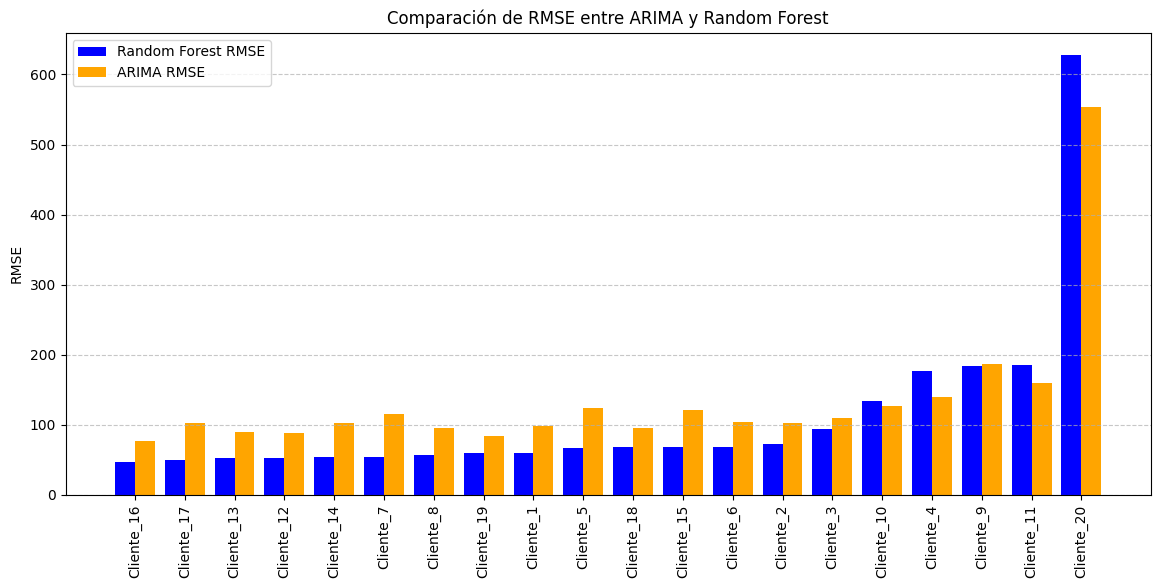

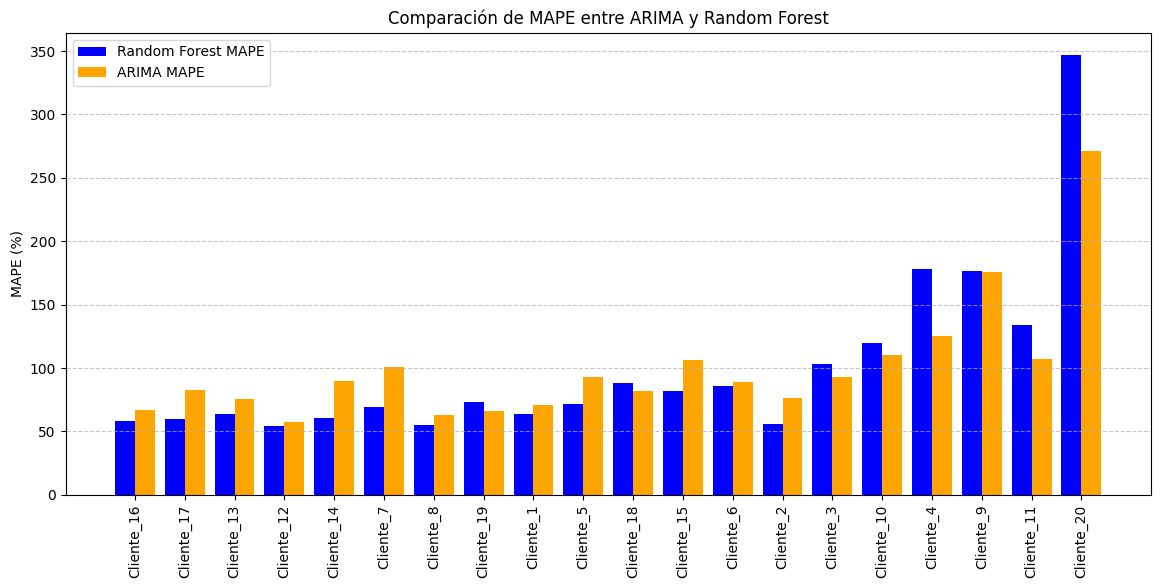

In [100]:
# Código para Visualización de RMSE y MAPE

df_comparacion_final = df_comparacion.copy()
df_comparacion_final["MAPE_RF"] = (abs(df_comparacion_final["MAE_RF"]) / df_comparacion_final["MAE_RF"].mean()) * 100
df_comparacion_final["MAPE_ARIMA"] = (abs(df_comparacion_final["MAE_ARIMA"]) / df_comparacion_final["MAE_ARIMA"].mean()) * 100
df_comparacion_final = df_comparacion_final.sort_values(by="RMSE_RF")

# Gráfico de barras comparando RMSE
plt.figure(figsize=(14, 6))
bar_width = 0.4
clientes = np.arange(len(df_comparacion_final))

plt.bar(clientes - bar_width / 2, df_comparacion_final["RMSE_RF"], width=bar_width, label="Random Forest RMSE", color="blue")
plt.bar(clientes + bar_width / 2, df_comparacion_final["RMSE_ARIMA"], width=bar_width, label="ARIMA RMSE", color="orange")

plt.xticks(clientes, df_comparacion_final.index, rotation=90)
plt.ylabel("RMSE")
plt.title("Comparación de RMSE entre ARIMA y Random Forest")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Gráfico de barras comparando MAPE
plt.figure(figsize=(14, 6))

plt.bar(clientes - bar_width / 2, df_comparacion_final["MAPE_RF"], width=bar_width, label="Random Forest MAPE", color="blue")
plt.bar(clientes + bar_width / 2, df_comparacion_final["MAPE_ARIMA"], width=bar_width, label="ARIMA MAPE", color="orange")

plt.xticks(clientes, df_comparacion_final.index, rotation=90)
plt.ylabel("MAPE (%)")
plt.title("Comparación de MAPE entre ARIMA y Random Forest")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


Comparación de Predicciones


📊 Comparación de Predicciones entre ARIMA y Random Forest
       Cliente  Predicción Order_Demand_ARIMA  Predicción Order_Demand_RF  \
0    Cliente_1                         654.11                      822.04   
1   Cliente_10                         754.86                      687.34   
2   Cliente_11                         854.42                      739.07   
3   Cliente_12                         725.27                      747.67   
4   Cliente_13                         765.33                      853.67   
5   Cliente_14                         691.54                      764.43   
6   Cliente_15                         691.24                      745.31   
7   Cliente_16                         745.91                      748.32   
8   Cliente_17                         754.90                      727.99   
9   Cliente_18                         825.57                      777.86   
10  Cliente_19                         734.08                      798.82   
11   Cliente_2   

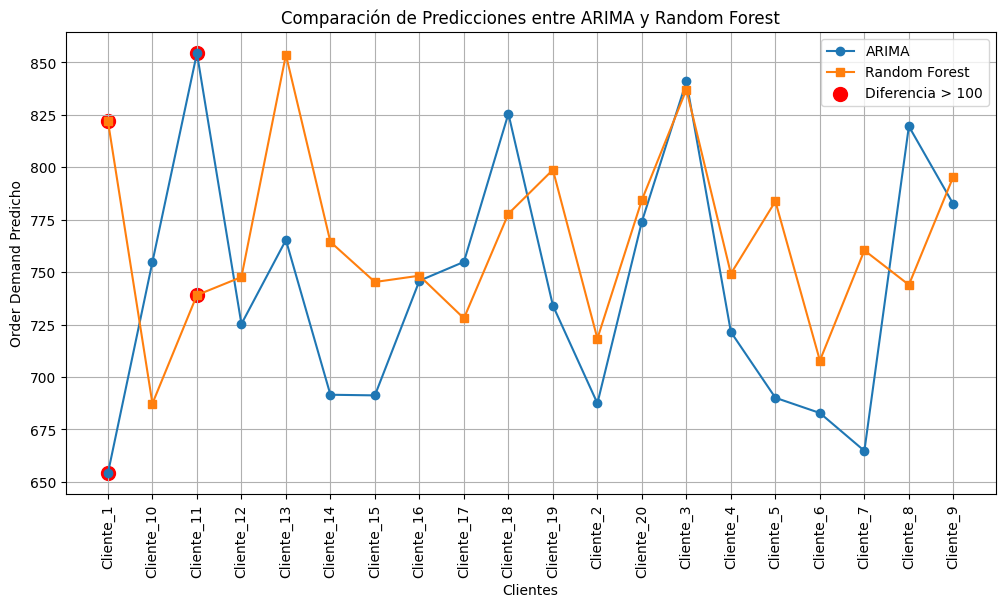

Cliente  Predicción Order_Demand_ARIMA  Predicción Order_Demand_RF  \
0    Cliente_1                         654.11                      822.04   
1   Cliente_10                         754.86                      687.34   
2   Cliente_11                         854.42                      739.07   
3   Cliente_12                         725.27                      747.67   
4   Cliente_13                         765.33                      853.67   
5   Cliente_14                         691.54                      764.43   
6   Cliente_15                         691.24                      745.31   
7   Cliente_16                         745.91                      748.32   
8   Cliente_17                         754.90                      727.99   
9   Cliente_18                         825.57                      777.86   
10  Cliente_19                         734.08                      798.82   
11   Cliente_2                         687.45                      718.32   
12  Cliente_20                         774.12                      784.46   
13   Cliente_3                         841.01                      837.09   
14   Cliente_4                         721.47                      749.28   
15   Cliente_5                         690.10                      783.79   
16   Cliente_6                         682.83                      707.82   
17   Cliente_7                         664.78                      760.40   
18   Cliente_8                         819.57                      743.96   
19   Cliente_9                         782.38                      795.62   

    Diferencia_Abs  
0           167.93  
1            67.52  
2           115.35  
3            22.40  
4            88.34  
5            72.89  
6            54.07  
7             2.41  
8            26.91  
9            47.71  
10           64.74  
11           30.86  
12           10.34  
13            3.91  
14           27.81  
15           93.69  
16           24.99  
17           95.61  
18           75.60  
19           13.24

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Crear un DataFrame combinando ambas predicciones
df_comparacion_predicciones = df_predicciones_arima.merge(
    df_predicciones_rf, on="Cliente", suffixes=("_ARIMA", "_RF")
)

# Calcular diferencia absoluta entre ambos modelos
df_comparacion_predicciones["Diferencia_Abs"] = abs(
    df_comparacion_predicciones["Predicción Order_Demand_ARIMA"] - df_comparacion_predicciones["Predicción Order_Demand_RF"]
)

# Filtrar clientes con diferencia > 100
clientes_diferencia_alta = df_comparacion_predicciones[df_comparacion_predicciones["Diferencia_Abs"] > 100]

# Mostrar la tabla con diferencias destacadas
print("\n📊 Comparación de Predicciones entre ARIMA y Random Forest")
print(df_comparacion_predicciones)

# Graficar la comparación
plt.figure(figsize=(12, 6))

clientes = df_comparacion_predicciones["Cliente"]
arima_preds = df_comparacion_predicciones["Predicción Order_Demand_ARIMA"]
rf_preds = df_comparacion_predicciones["Predicción Order_Demand_RF"]

plt.plot(clientes, arima_preds, marker='o', linestyle='-', label="ARIMA")
plt.plot(clientes, rf_preds, marker='s', linestyle='-', label="Random Forest")

# Resaltar los clientes con mayor diferencia en la gráfica
for i, row in clientes_diferencia_alta.iterrows():
    plt.scatter(row["Cliente"], row["Predicción Order_Demand_ARIMA"], color='red', s=100, label="Diferencia > 100" if i == clientes_diferencia_alta.index[0] else "")
    plt.scatter(row["Cliente"], row["Predicción Order_Demand_RF"], color='red', s=100)

plt.xticks(rotation=90)
plt.xlabel("Clientes")
plt.ylabel("Order Demand Predicho")
plt.title("Comparación de Predicciones entre ARIMA y Random Forest")
plt.legend()
plt.grid()
plt.show()

df_comparacion_predicciones